# **Imports**

In [ ]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=09b888b5287a9d154fd4c8f9ac4dd82beccb9eca3f452021100f96d1420f8cc0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import RFE
import shap
import lime
import lime.lime_tabular

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# **Data Loading**

In [ ]:
path = kagglehub.dataset_download("hassan06/nslkdd")
train_path = os.path.join(path, 'KDDTrain+.txt')
test_path = os.path.join(path, 'KDDTest+.txt')

In [ ]:
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]

In [ ]:
train_df = pd.read_csv(train_path, header=None, names=column_names)
test_df = pd.read_csv(test_path, header=None, names=column_names)

# **1. Initial Data Exploration**

In [ ]:
print(train_df.shape)
print(test_df.shape)

(125973, 43)
(22544, 43)


In [ ]:
# Missing Data
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


In [ ]:
# Duplicates
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [ ]:
# Data Description
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

# **2. EDA**

In [ ]:
print("\nAttack Distribution in Training Data:")
attack_counts = train_df['attack'].value_counts()
print(attack_counts)


Attack Distribution in Training Data:
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


The following Bar Plot show the top 10 attack types based on the training data, which appear that normal and neptune have the most frequent and show the imbalance in attack distribution.

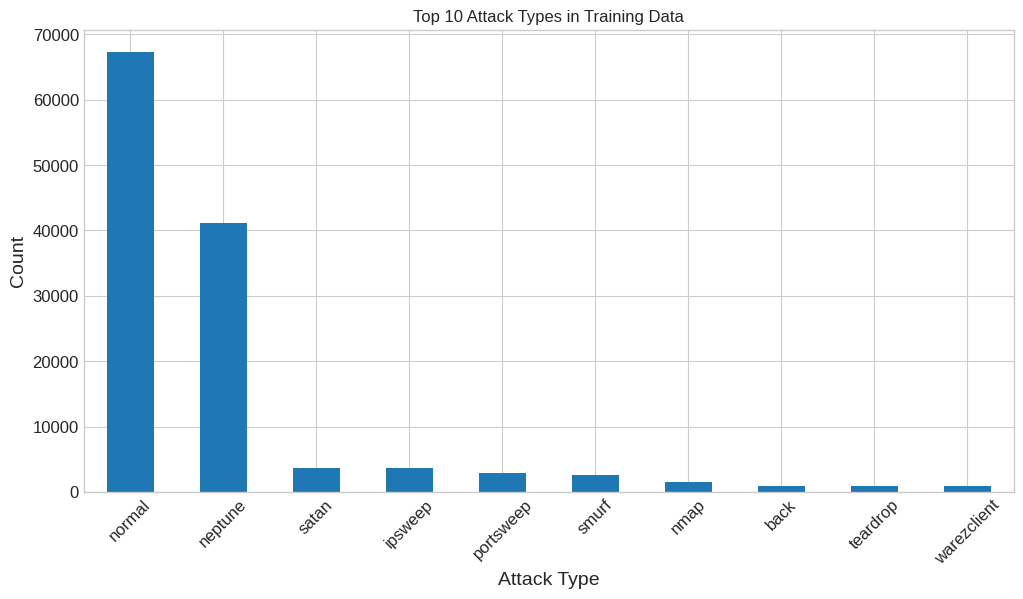

In [ ]:
plt.figure(figsize=(12, 6))
attack_counts[:10].plot(kind='bar')
plt.title('Top 10 Attack Types in Training Data')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

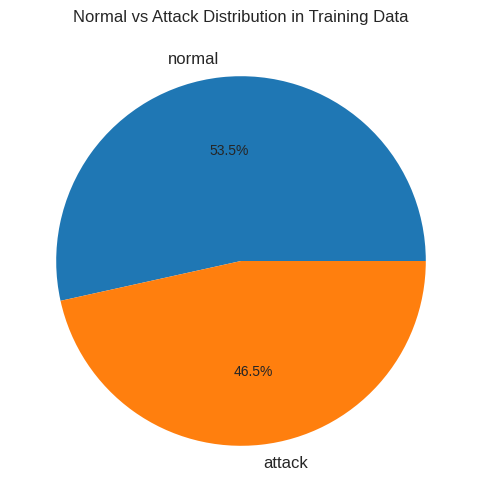

In [ ]:
binary_distribution = train_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'attack').value_counts()
plt.figure(figsize=(8, 6))
binary_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Normal vs Attack Distribution in Training Data')
plt.ylabel('')
plt.show()

In [ ]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('level')

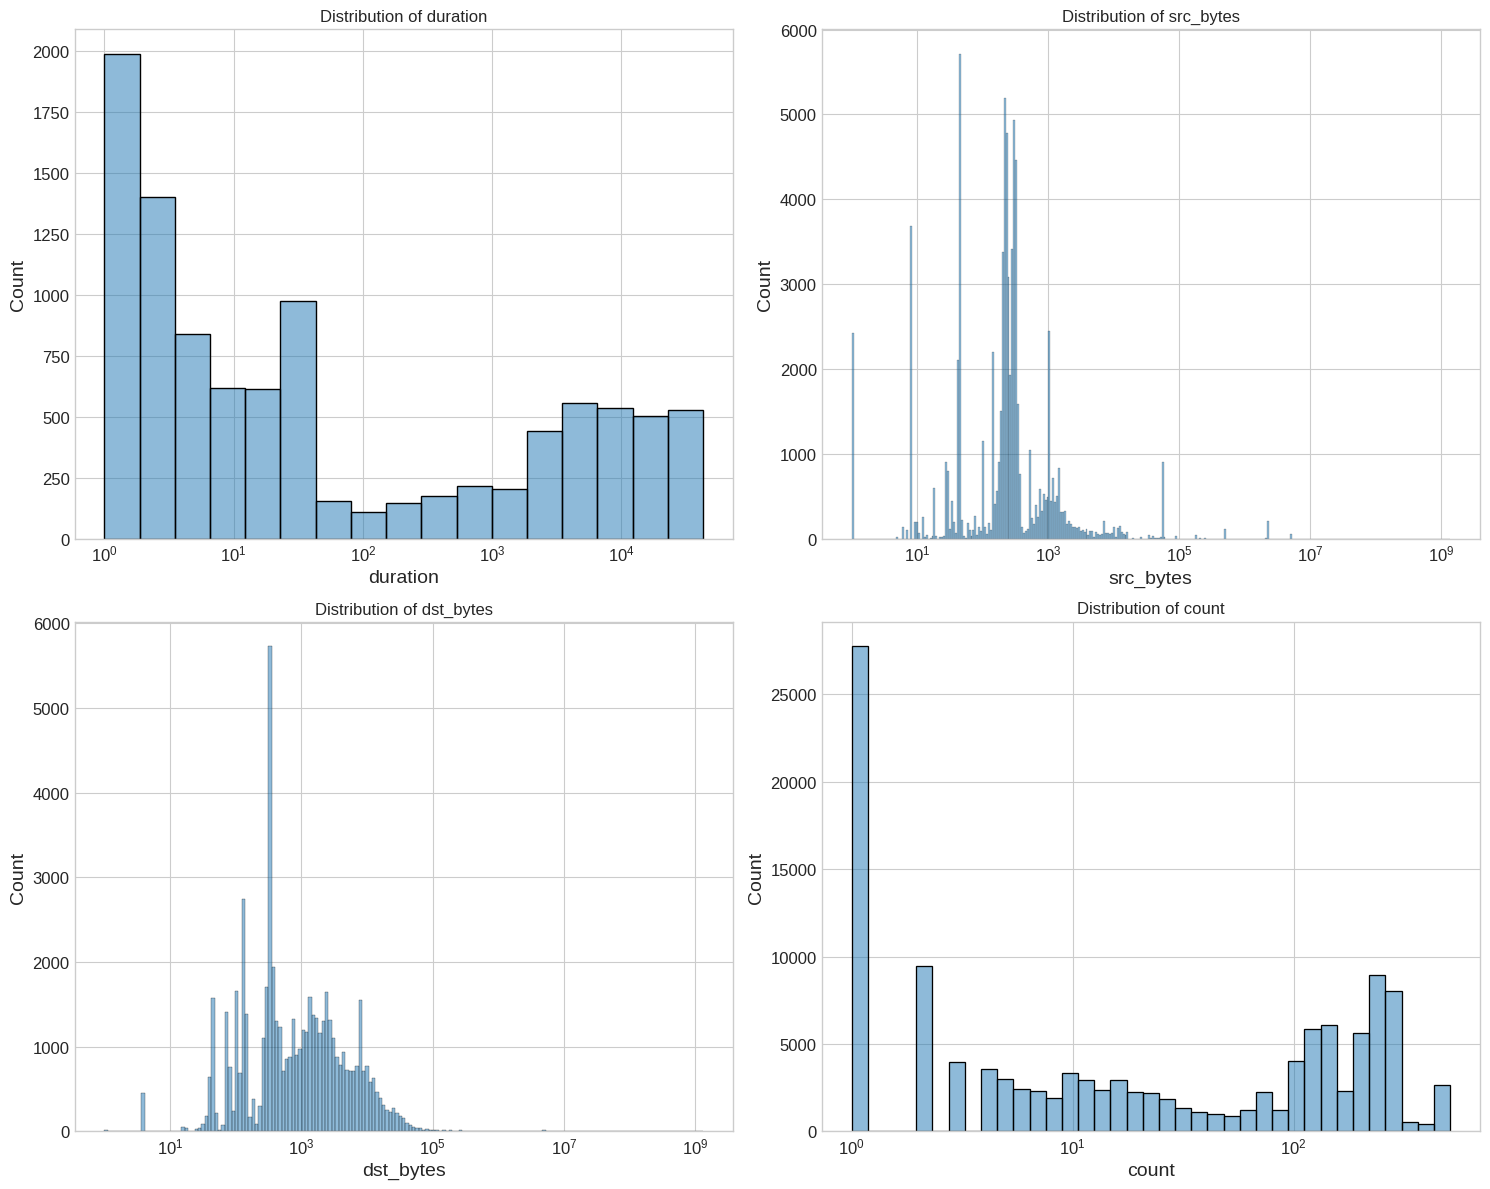

In [ ]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(['duration', 'src_bytes', 'dst_bytes', 'count']):
    plt.subplot(2, 2, i+1)
    sns.histplot(train_df[feature], kde=True, log_scale=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

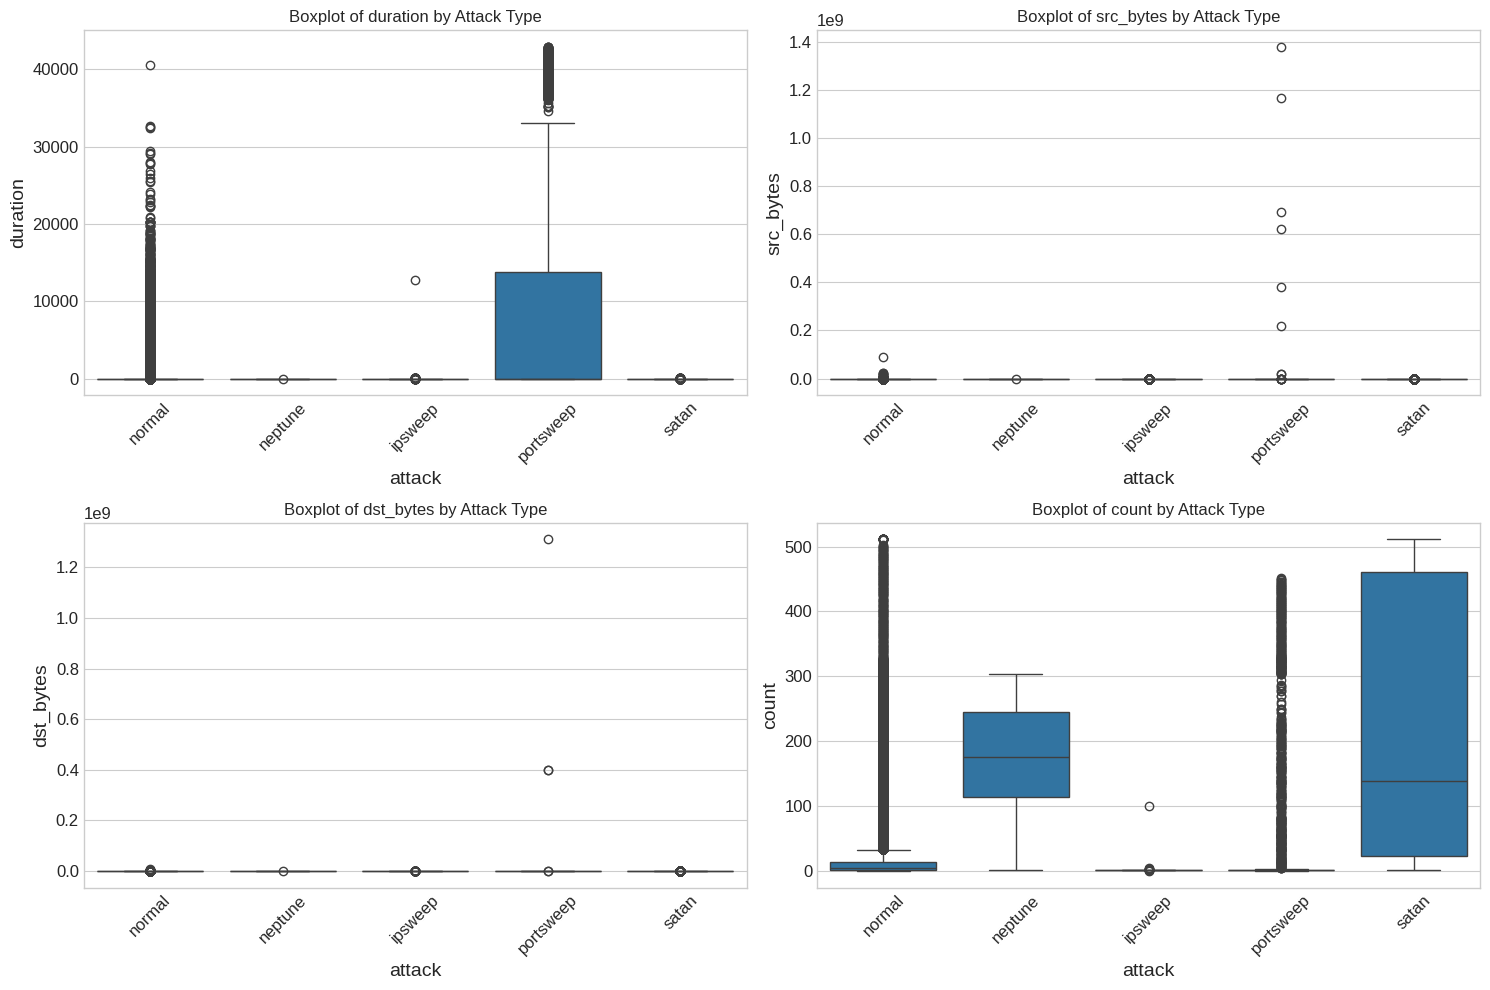

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['duration', 'src_bytes', 'dst_bytes', 'count']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='attack', y=feature, data=train_df[train_df['attack'].isin(['normal', 'neptune', 'satan', 'ipsweep', 'portsweep'])])
    plt.title(f'Boxplot of {feature} by Attack Type')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

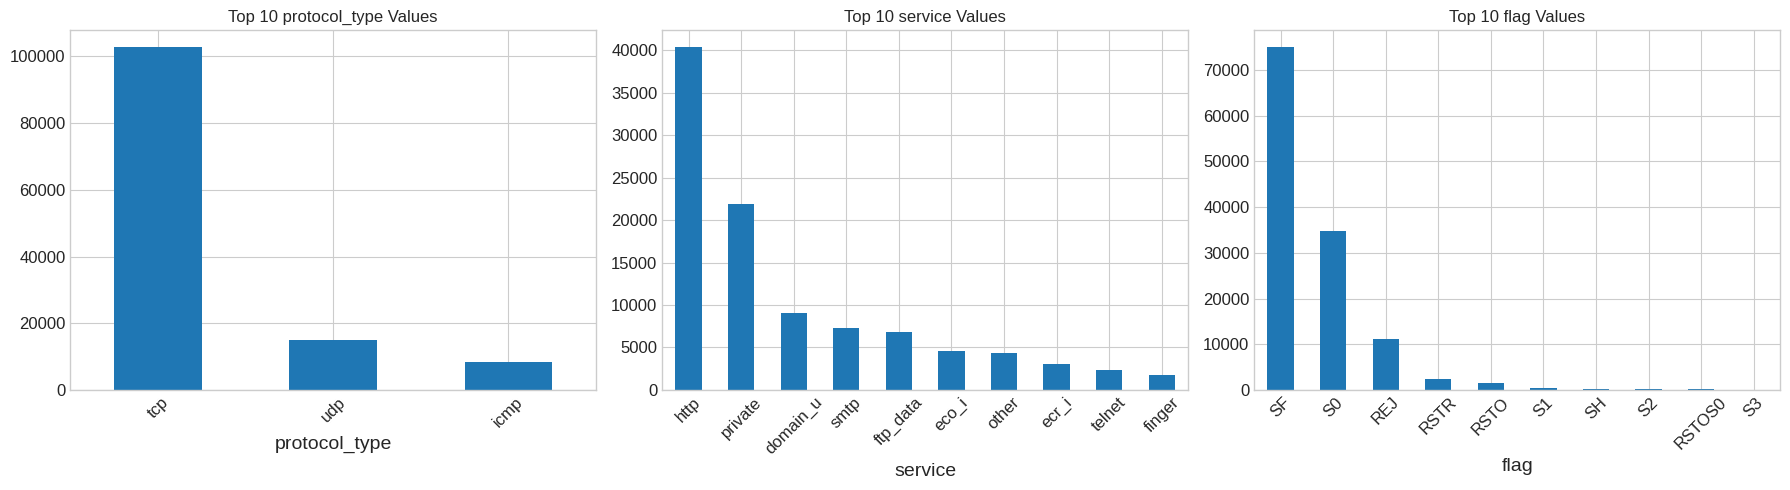

In [ ]:
cat_features = ['protocol_type', 'service', 'flag']
plt.figure(figsize=(18, 5))
for i, feature in enumerate(cat_features):
    plt.subplot(1, 3, i+1)
    train_df[feature].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {feature} Values')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

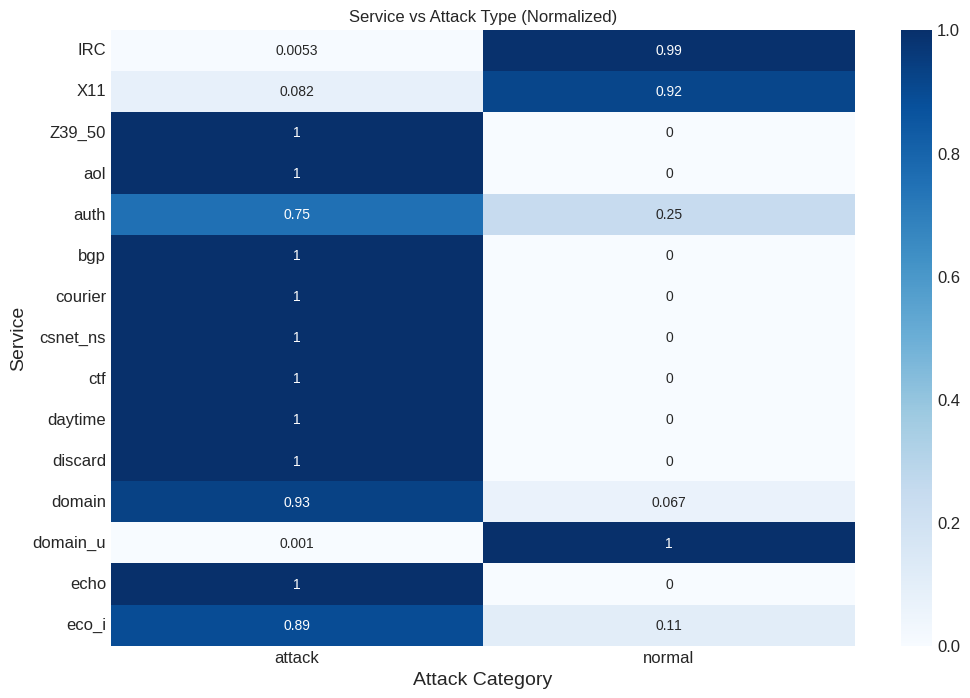

In [ ]:
plt.figure(figsize=(12, 8))
service_attack = pd.crosstab(train_df['service'], train_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'attack'))
service_attack_norm = service_attack.div(service_attack.sum(axis=1), axis=0)
sns.heatmap(service_attack_norm.iloc[:15], annot=True, cmap='Blues')
plt.title('Service vs Attack Type (Normalized)')
plt.xlabel('Attack Category')
plt.ylabel('Service')
plt.show()

In [ ]:
feature_groups = {
    'byte_features': ['src_bytes', 'dst_bytes'],
    'duration_features': ['duration'],
    'count_features': ['count', 'srv_count', 'dst_host_count', 'dst_host_srv_count'],
    'rate_features': [
        'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
    ],
    'binary_features': [
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
        'num_outbound_cmds', 'is_host_login', 'is_guest_login'
    ],
    'categorical_features': ['protocol_type', 'service', 'flag']
}


In [ ]:
byte_features = feature_groups['byte_features']
duration_features = feature_groups['duration_features']
count_features = feature_groups['count_features']
rate_features = feature_groups['rate_features']
binary_features = feature_groups['binary_features']
categorical_features = feature_groups['categorical_features']

# **3. Outlier Detection and Analysis**

In [ ]:
def detect_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

In [ ]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
print("\nOutliers in numerical features:")
for col in numerical_columns:
    outlier_count = detect_outlier(train_df, col)
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers")


Outliers in numerical features:
duration: 10018 outliers
src_bytes: 13840 outliers
dst_bytes: 23579 outliers
land: 25 outliers
wrong_fragment: 1090 outliers
urgent: 9 outliers
hot: 2671 outliers
num_failed_logins: 122 outliers
num_compromised: 1286 outliers
root_shell: 169 outliers
su_attempted: 80 outliers
num_root: 649 outliers
num_file_creations: 287 outliers
num_shells: 47 outliers
num_access_files: 371 outliers
is_host_login: 1 outliers
is_guest_login: 1187 outliers
count: 3157 outliers
srv_count: 12054 outliers
rerror_rate: 16190 outliers
srv_rerror_rate: 16206 outliers
diff_srv_rate: 7788 outliers
srv_diff_host_rate: 28399 outliers
dst_host_diff_srv_rate: 10550 outliers
dst_host_same_src_port_rate: 25052 outliers
dst_host_srv_diff_host_rate: 11682 outliers
dst_host_rerror_rate: 22795 outliers
dst_host_srv_rerror_rate: 19357 outliers
level: 2995 outliers


# **4. Data Preparation and Feature Engineering**

In [ ]:
train_copy_df = train_df.copy()
test_copy_df = test_df.copy()
train_idx = len(train_copy_df)
df_combined = pd.concat([train_copy_df, test_copy_df], axis=0)

In [ ]:
df_combined['binary_target'] = df_combined['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [ ]:
attack_categories = {
    'normal': 'normal',
    'neptune': 'dos', 'smurf': 'dos', 'pod': 'dos', 'teardrop': 'dos',
    'land': 'dos', 'back': 'dos', 'apache2': 'dos', 'udpstorm': 'dos',
    'processtable': 'dos', 'mailbomb': 'dos',
    'ipsweep': 'probe', 'portsweep': 'probe', 'nmap': 'probe', 'satan': 'probe',
    'mscan': 'probe', 'saint': 'probe',
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'xterm': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'httptunnel': 'u2r',
    'ftp_write': 'r2l', 'phf': 'r2l', 'guess_passwd': 'r2l', 'warezmaster': 'r2l',
    'warezclient': 'r2l', 'imap': 'r2l', 'spy': 'r2l', 'multihop': 'r2l',
    'named': 'r2l', 'snmpguess': 'r2l', 'worm': 'r2l', 'snmpgetattack': 'r2l',
    'xsnoop': 'r2l', 'xlock': 'r2l', 'sendmail': 'r2l'
}

df_combined['attack_category'] = df_combined['attack'].map(lambda x: attack_categories.get(x, 'unknown'))

In [ ]:
category_mapping = {cat: idx for idx, cat in enumerate(df_combined['attack_category'].unique())}
df_combined['attack_category_encoded'] = df_combined['attack_category'].map(category_mapping)

In [ ]:
print("\nAttack category distribution:")
print(df_combined['attack_category'].value_counts())


Attack category distribution:
attack_category
normal    77054
dos       53385
probe     14077
r2l        3749
u2r         252
Name: count, dtype: int64


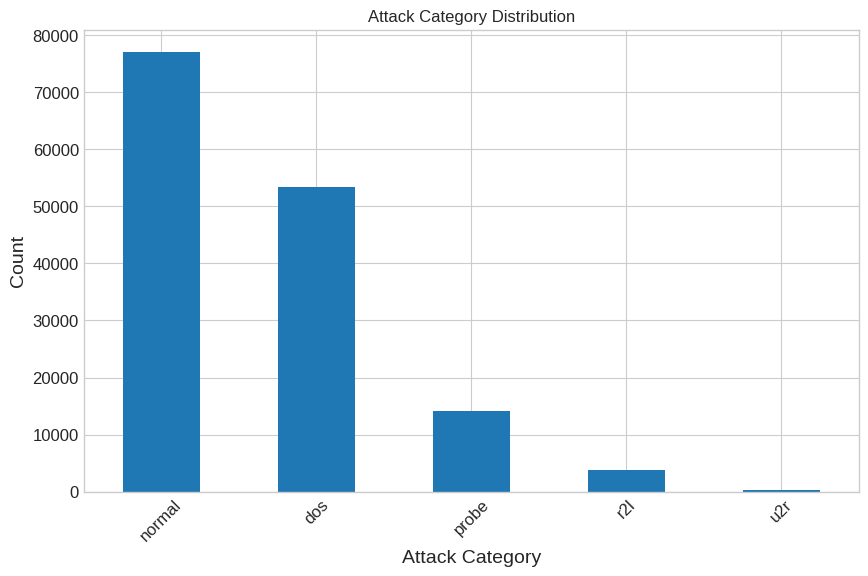

In [ ]:
plt.figure(figsize=(10, 6))
df_combined['attack_category'].value_counts().plot(kind='bar')
plt.title('Attack Category Distribution')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **5. Feature Transformation**

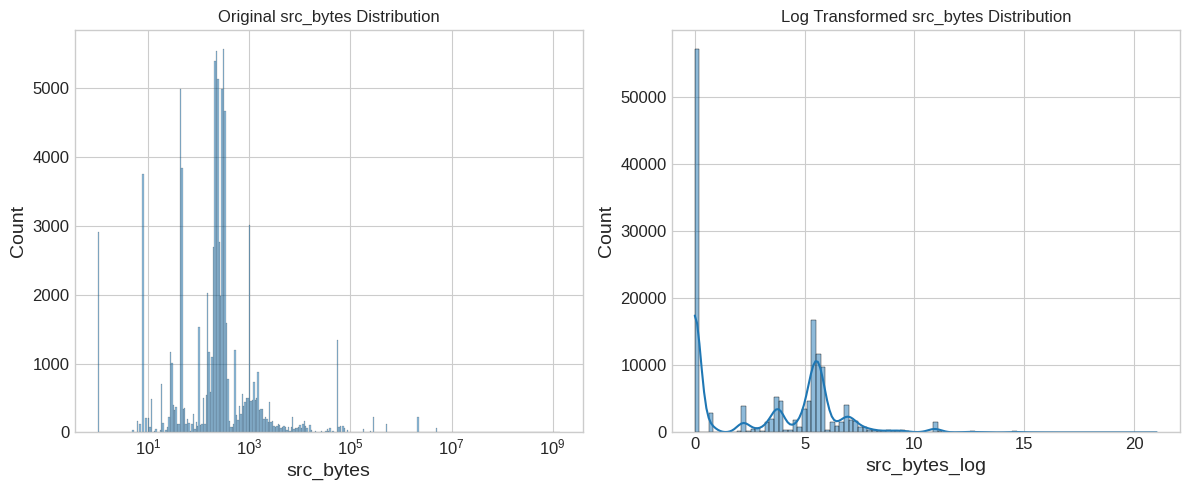

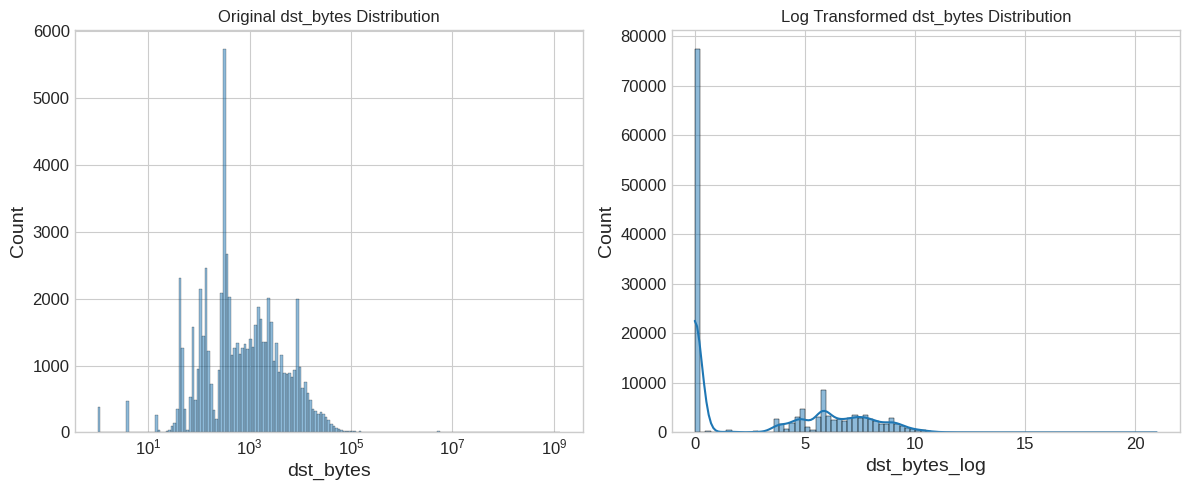

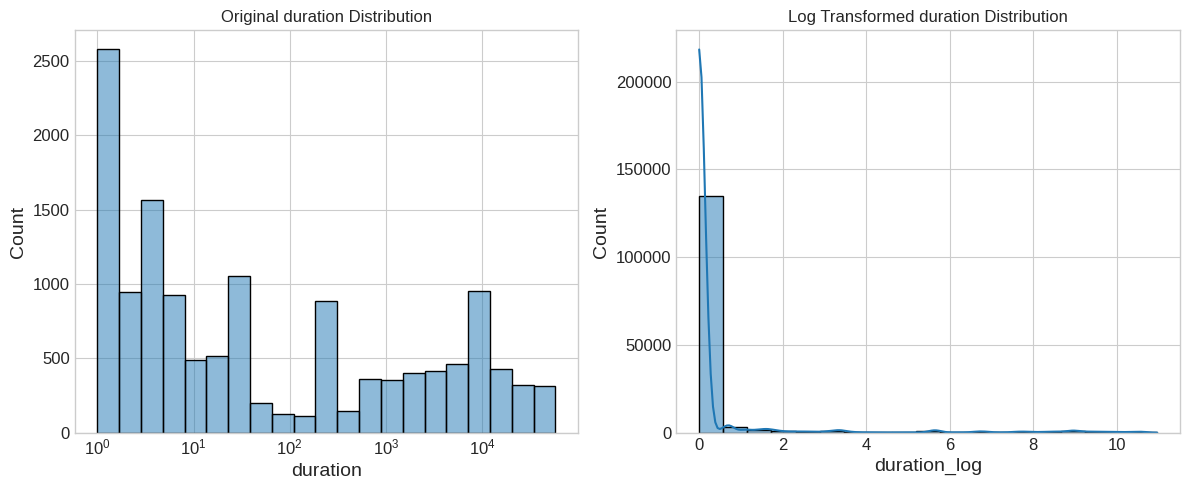

In [ ]:
for feature in byte_features + duration_features:
    df_combined[f'{feature}_log'] = np.log1p(df_combined[feature])

    # Plot original vs transformed distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_combined[feature], kde=True, log_scale=True)
    plt.title(f'Original {feature} Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(df_combined[f'{feature}_log'], kde=True)
    plt.title(f'Log Transformed {feature} Distribution')
    plt.tight_layout()
    plt.show()

In [ ]:
df_encoded = pd.get_dummies(df_combined, columns=categorical_features, drop_first=False)

In [ ]:
rate_scaler = RobustScaler()
rate_scaled = rate_scaler.fit_transform(df_encoded[rate_features])
rate_scaled_df = pd.DataFrame(
    rate_scaled,
    columns=[f'{col}_scaled' for col in rate_features],
    index=df_encoded.index
)

In [ ]:
count_scaler = RobustScaler()
count_scaled = count_scaler.fit_transform(df_encoded[count_features])
count_scaled_df = pd.DataFrame(
    count_scaled,
    columns=[f'{col}_scaled' for col in count_features],
    index=df_encoded.index
)

In [ ]:
df_processed = df_encoded.copy()
df_processed = pd.concat([df_processed, rate_scaled_df, count_scaled_df], axis=1)

# **6. Feature Selection and Importance**

In [ ]:
cols_to_drop = ['attack', 'level']
X = df_processed.drop(cols_to_drop + ['binary_target', 'attack_category', 'attack_category_encoded'], axis=1)

scaled_features = [col for col in X.columns if "_scaled" in col]
original_features_to_drop = [col.replace("_scaled", "") for col in scaled_features]

X_better = X.drop(columns=original_features_to_drop)

X_train = X_better.iloc[:train_idx]
X_test = X_better.iloc[train_idx:]


In [ ]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125973 entries, 0 to 125972
Columns: 125 entries, duration to dst_host_srv_count_scaled
dtypes: bool(84), float64(22), int64(19)
memory usage: 50.5 MB
<class 'pandas.core.frame.DataFrame'>
Index: 22544 entries, 0 to 22543
Columns: 125 entries, duration to dst_host_srv_count_scaled
dtypes: bool(84), float64(22), int64(19)
memory usage: 9.0 MB


In [ ]:
# Binary Classification Target
y_train_binary = df_processed['binary_target'].iloc[:train_idx]
y_test_binary = df_processed['binary_target'].iloc[train_idx:]

In [ ]:
# Multiclass classification targets
y_train_multi = df_processed['attack_category_encoded'].iloc[:train_idx]
y_test_multi = df_processed['attack_category_encoded'].iloc[train_idx:]

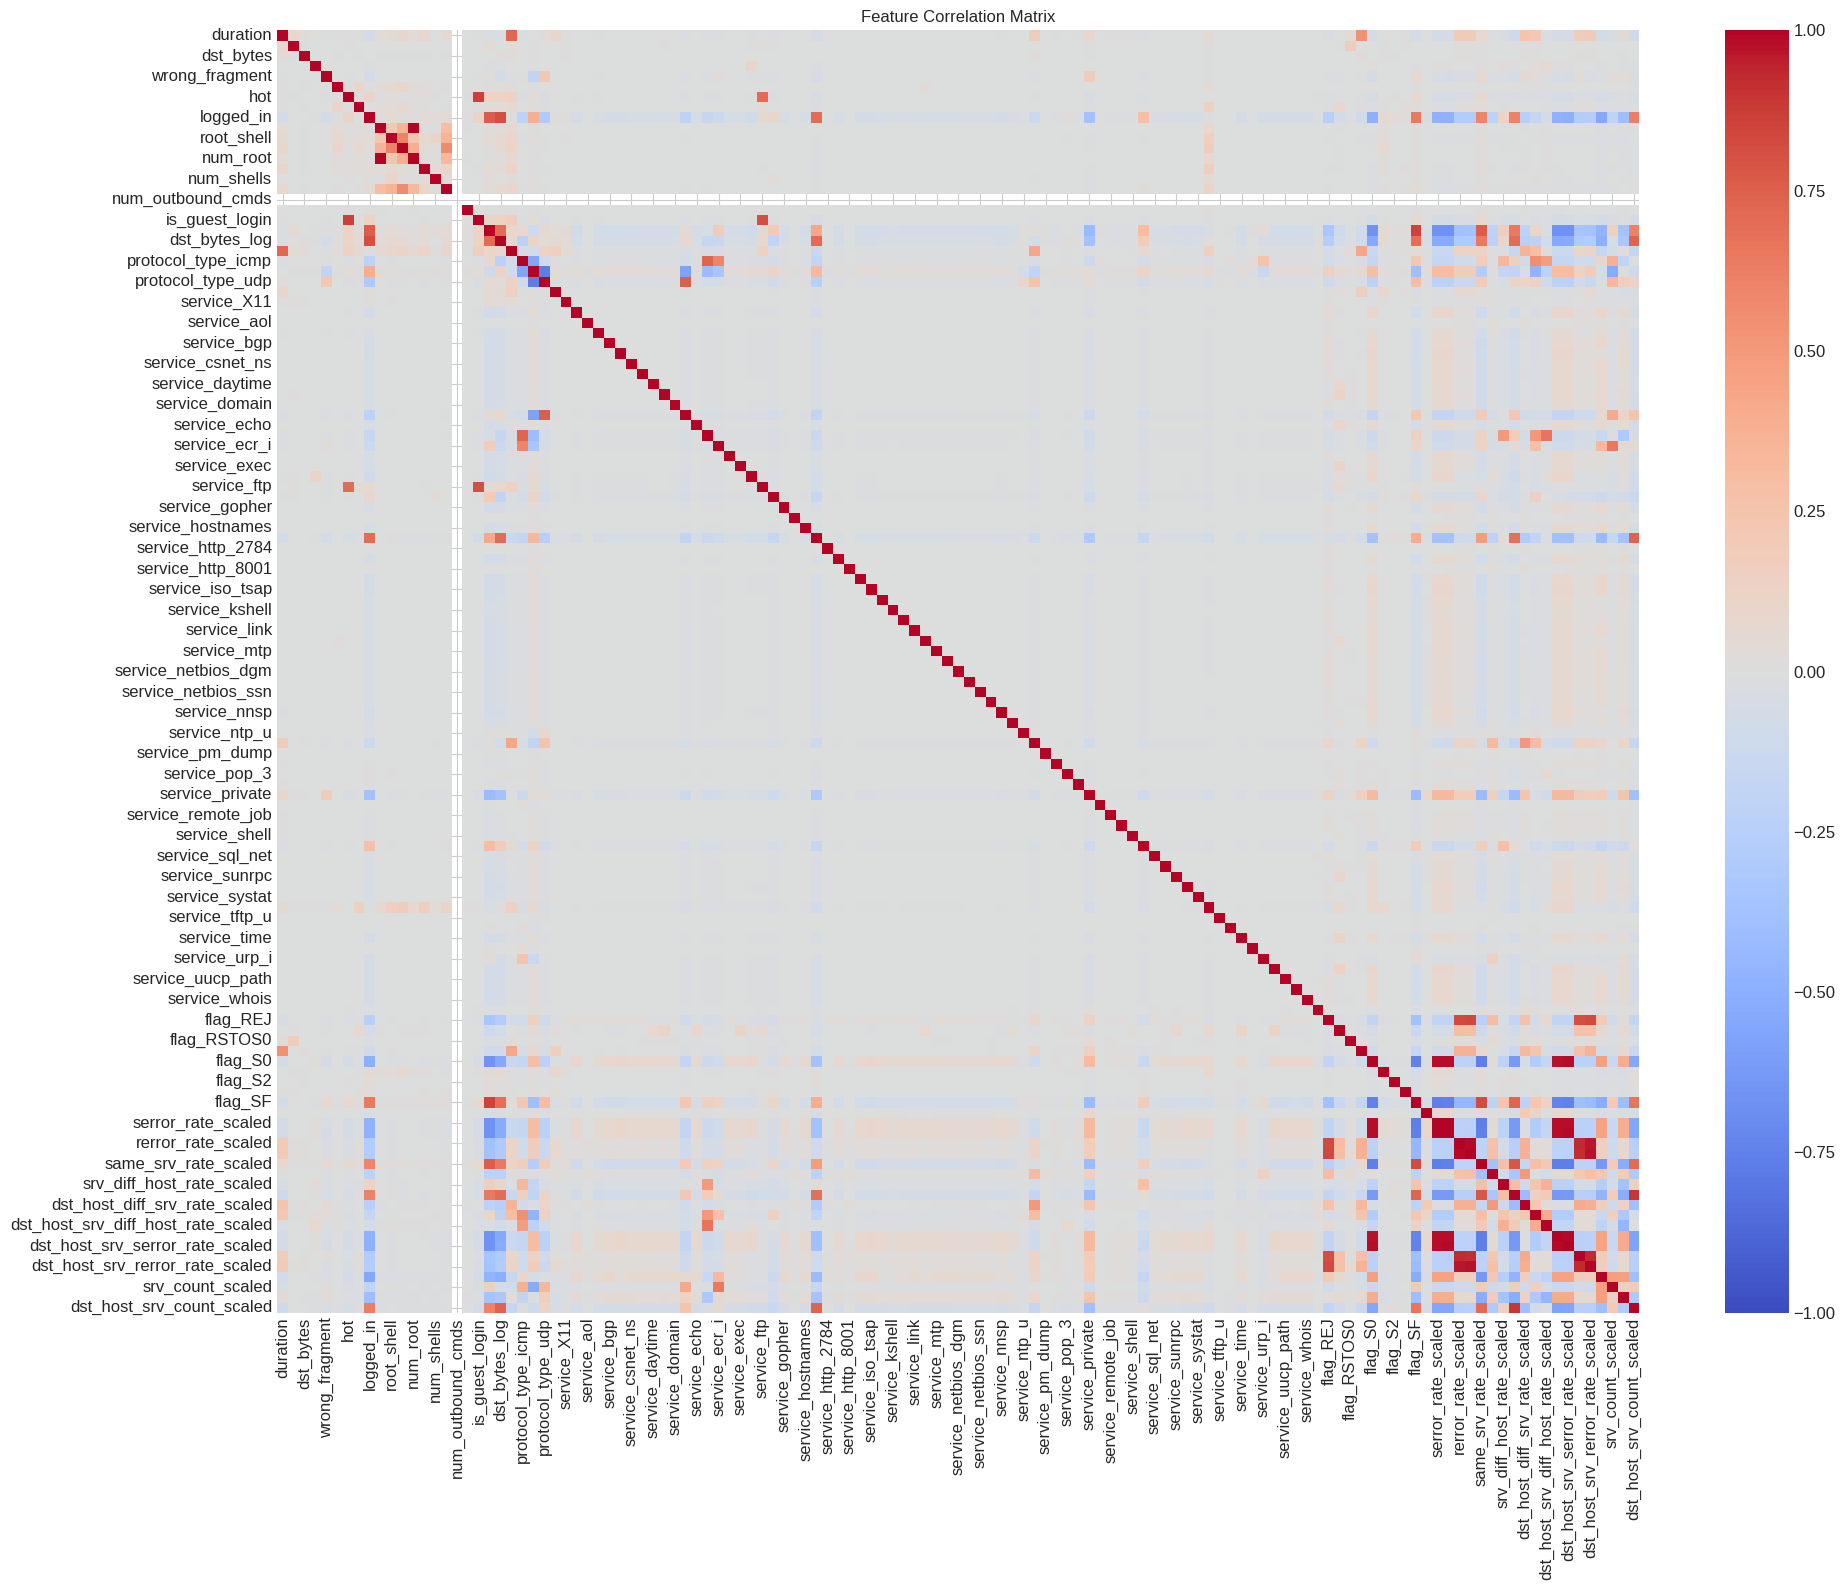

In [ ]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

1.   Redundant Features: Highly correlated features can introduce multicollinearity in models like logistic regression or linear classifiers. You might want to remove one of each such pair.
2.   Feature Selection: You can choose less correlated, more independent features for better generalization.
3. Model Performance: Reducing correlated inputs can improve interpretability and reduce overfitting.

In [ ]:
better_correlation_matrix = X_better.corr()

high_corr_threshold = 0.95
high_corr_features = set()

for i in range(len(better_correlation_matrix.columns)):
    for j in range(i):
        if abs(better_correlation_matrix.iloc[i, j]) > high_corr_threshold:
            feature_pair = (better_correlation_matrix.columns[i], better_correlation_matrix.columns[j])
            high_corr_features.add(feature_pair)

if high_corr_features:
    print("\nHighly correlated feature pairs (correlation > 0.95):")
    for feature1, feature2 in high_corr_features:
        corr_value = better_correlation_matrix.loc[feature1, feature2]
        print(f"{feature1} and {feature2}: {corr_value:.4f}")


Highly correlated feature pairs (correlation > 0.95):
dst_host_srv_serror_rate_scaled and serror_rate_scaled: 0.9760
dst_host_serror_rate_scaled and srv_serror_rate_scaled: 0.9708
dst_host_srv_serror_rate_scaled and flag_S0: 0.9755
dst_host_srv_rerror_rate_scaled and rerror_rate_scaled: 0.9574
num_root and num_compromised: 0.9987
dst_host_srv_serror_rate_scaled and srv_serror_rate_scaled: 0.9820
dst_host_serror_rate_scaled and serror_rate_scaled: 0.9747
dst_host_serror_rate_scaled and flag_S0: 0.9696
dst_host_srv_serror_rate_scaled and dst_host_serror_rate_scaled: 0.9828
serror_rate_scaled and flag_S0: 0.9727
srv_rerror_rate_scaled and rerror_rate_scaled: 0.9861
dst_host_srv_rerror_rate_scaled and srv_rerror_rate_scaled: 0.9656
srv_serror_rate_scaled and flag_S0: 0.9768
srv_serror_rate_scaled and serror_rate_scaled: 0.9915


In [ ]:
print("\nPerforming ANOVA F-test for binary classification...")
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_train, y_train_binary)
anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': anova_selector.scores_,
    'P_Value': anova_selector.pvalues_
})
anova_scores = anova_scores.sort_values('F_Score', ascending=False)


Performing ANOVA F-test for binary classification...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print("\nTop 20 features by ANOVA F-test (Binary Classification):")
print(anova_scores.head(20))


Top 20 features by ANOVA F-test (Binary Classification):
                             Feature        F_Score  P_Value
104                          flag_SF  168332.131565      0.0
20                     dst_bytes_log  164972.320416      0.0
110             same_srv_rate_scaled  163866.577206      0.0
19                     src_bytes_log  143274.967853      0.0
124        dst_host_srv_count_scaled  137598.286145      0.0
113    dst_host_same_srv_rate_scaled  116917.276744      0.0
8                          logged_in  114585.761111      0.0
118  dst_host_srv_serror_rate_scaled   94646.003539      0.0
117      dst_host_serror_rate_scaled   93069.951011      0.0
106               serror_rate_scaled   92481.504759      0.0
100                          flag_S0   92261.774118      0.0
107           srv_serror_rate_scaled   91324.684661      0.0
121                     count_scaled   62689.677518      0.0
49                      service_http   58249.601370      0.0
74                   servic

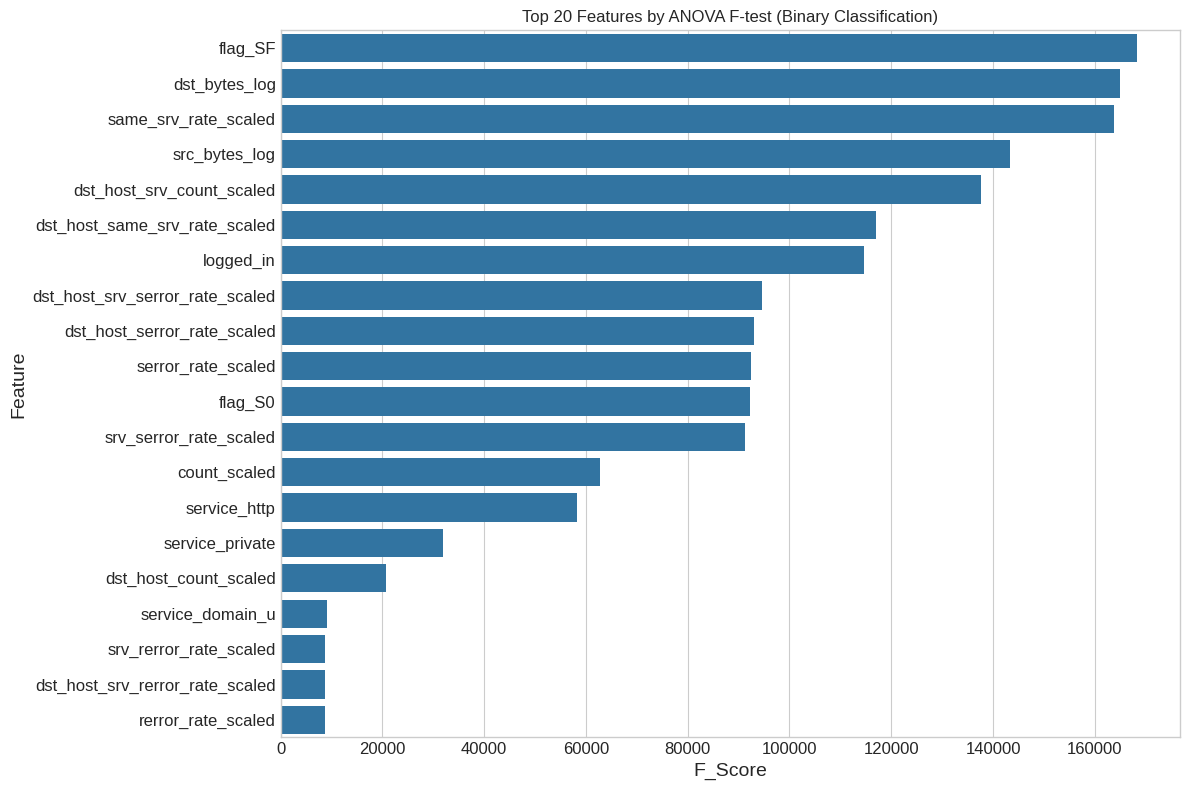

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='F_Score', y='Feature', data=anova_scores.head(20))
plt.title('Top 20 Features by ANOVA F-test (Binary Classification)')
plt.tight_layout()
plt.show()

# **7. Model Training - Binary Classification**

In [ ]:
print("\nApplying SMOTE for binary classification...")
print(f"Class distribution before SMOTE: {pd.Series(y_train_binary).value_counts()}")


Applying SMOTE for binary classification...
Class distribution before SMOTE: binary_target
0    67343
1    58630
Name: count, dtype: int64


In [ ]:
smote_binary = SMOTE(random_state=42)
X_train_binary_smote, y_train_binary_smote = smote_binary.fit_resample(X_train, y_train_binary)
print(f"Class distribution after SMOTE: {pd.Series(y_train_binary_smote).value_counts()}")


Class distribution after SMOTE: binary_target
0    67343
1    67343
Name: count, dtype: int64


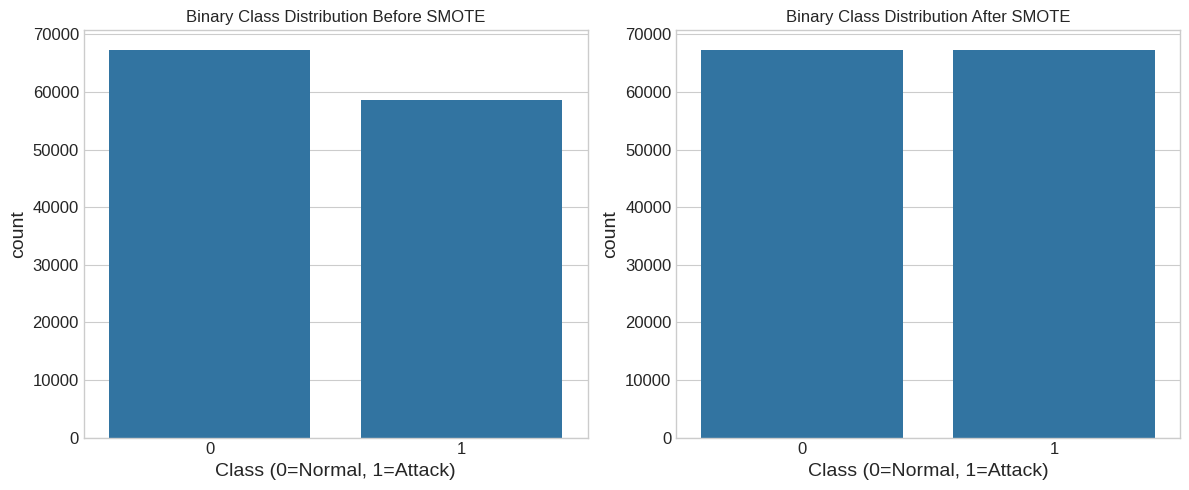

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_binary)
plt.title('Binary Class Distribution Before SMOTE')
plt.xlabel('Class (0=Normal, 1=Attack)')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_binary_smote)
plt.title('Binary Class Distribution After SMOTE')
plt.xlabel('Class (0=Normal, 1=Attack)')
plt.tight_layout()
plt.show()

In [ ]:
print("\nTraining Random Forest for binary classification...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_binary_smote, y_train_binary_smote)


Training Random Forest for binary classification...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Evaluate the model
y_pred_binary = rf.predict(X_test)
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Binary classification accuracy: {binary_accuracy:.4f}")

Binary classification accuracy: 0.7832


In [ ]:
print("\nClassification Report (Binary):")
print(classification_report(y_test_binary, y_pred_binary))


Classification Report (Binary):
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



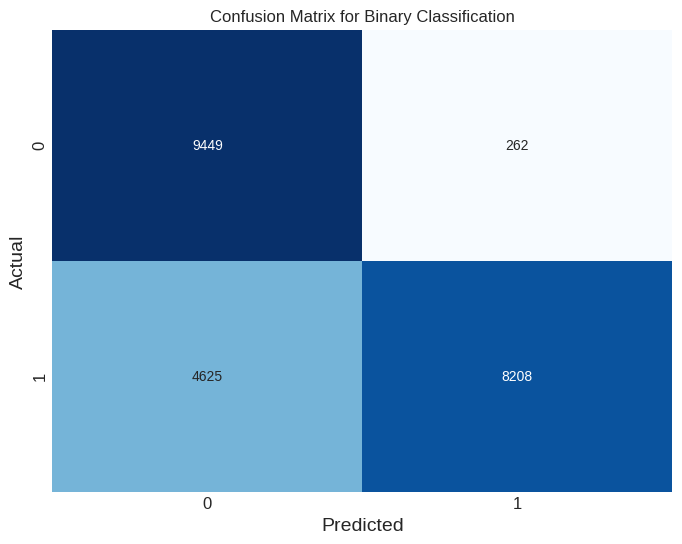

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

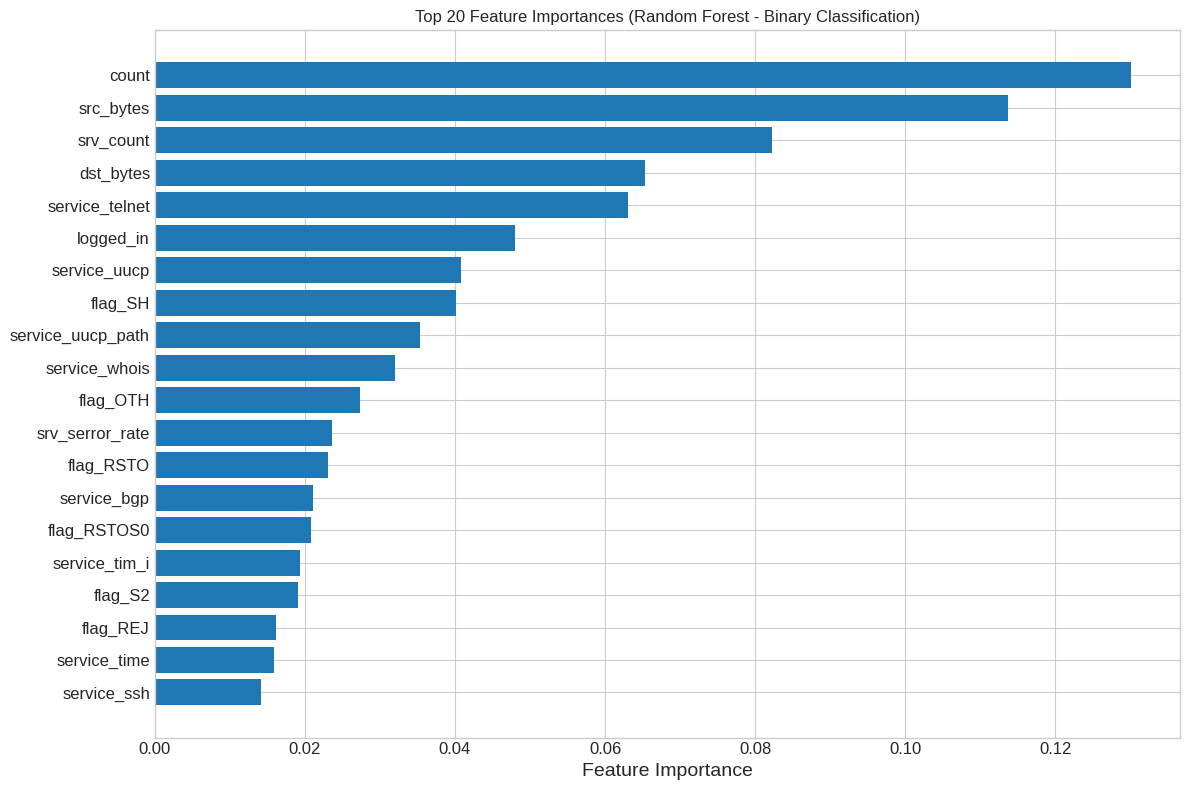

In [ ]:
plt.figure(figsize=(12, 8))
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest - Binary Classification)')
plt.tight_layout()
plt.show()

In [ ]:
print("Selecting important features...")
selector = SelectFromModel(rf, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
print(f"Number of selected features: {len(selected_features)}")
print("Top 10 selected features:")
for i, feature in enumerate(selected_features[:10]):
    print(f"{i+1}. {feature}")

Selecting important features...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features: 27
Top 10 selected features:
1. src_bytes
2. dst_bytes
3. logged_in
4. count
5. srv_count
6. srv_serror_rate
7. rerror_rate
8. duration_log
9. service_bgp
10. service_klogin


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

## **2. EDA**

In [ ]:
print("\nAttack Distribution in Training Data:")
attack_counts = train_df['attack'].value_counts()
print(attack_counts)


Attack Distribution in Training Data:
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


The following Bar Plot show the top 10 attack types based on the training data, which appear that normal and neptune have the most frequent and show the imbalance in attack distribution.

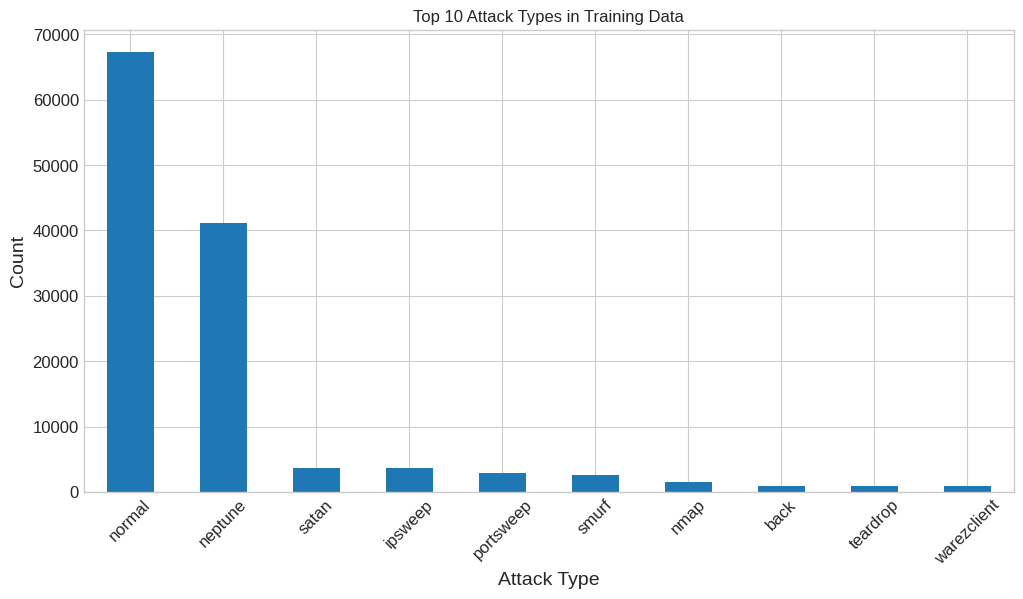

In [ ]:
plt.figure(figsize=(12, 6))
attack_counts[:10].plot(kind='bar')
plt.title('Top 10 Attack Types in Training Data')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The pie Chart plot show the distribution between normal(53.5) and attack(46.5) in the training data which show the the data close to be balanced between normal and attack.

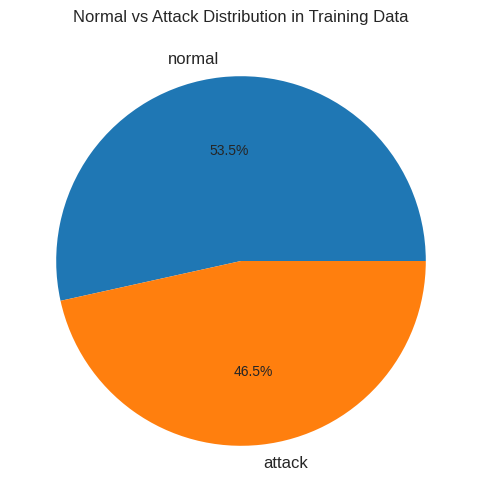

In [ ]:
binary_distribution = train_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'attack').value_counts()
plt.figure(figsize=(8, 6))
binary_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Normal vs Attack Distribution in Training Data')
plt.ylabel('')
plt.show()

In [ ]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('level')

The log-scaled transformation used to visualize some numerical features (duration, src_bytes, dst_bytes, count) to handle the outliers as these 4 columns has the most outliers in the dataset.

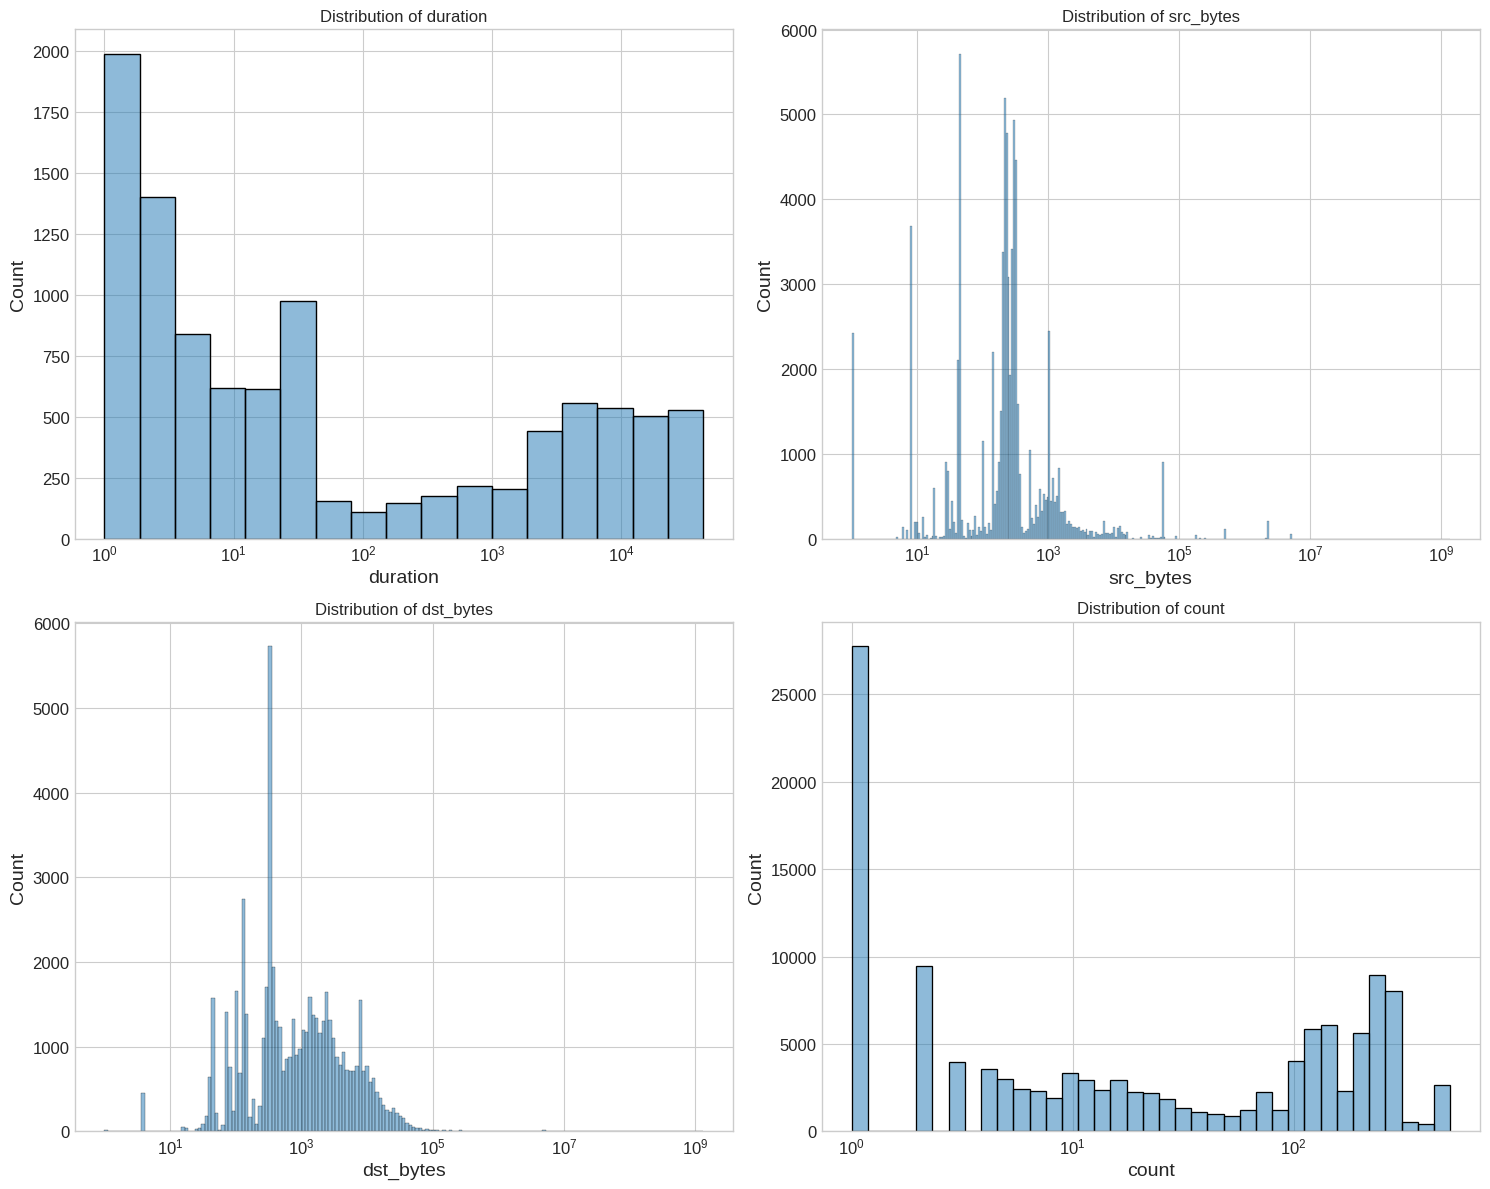

In [ ]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(['duration', 'src_bytes', 'dst_bytes', 'count']):
    plt.subplot(2, 2, i+1)
    sns.histplot(train_df[feature], kde=True, log_scale=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

The following Box Plot show the outlires distribution for the top columns cntain outlires to make it easy to detect and to be handled.

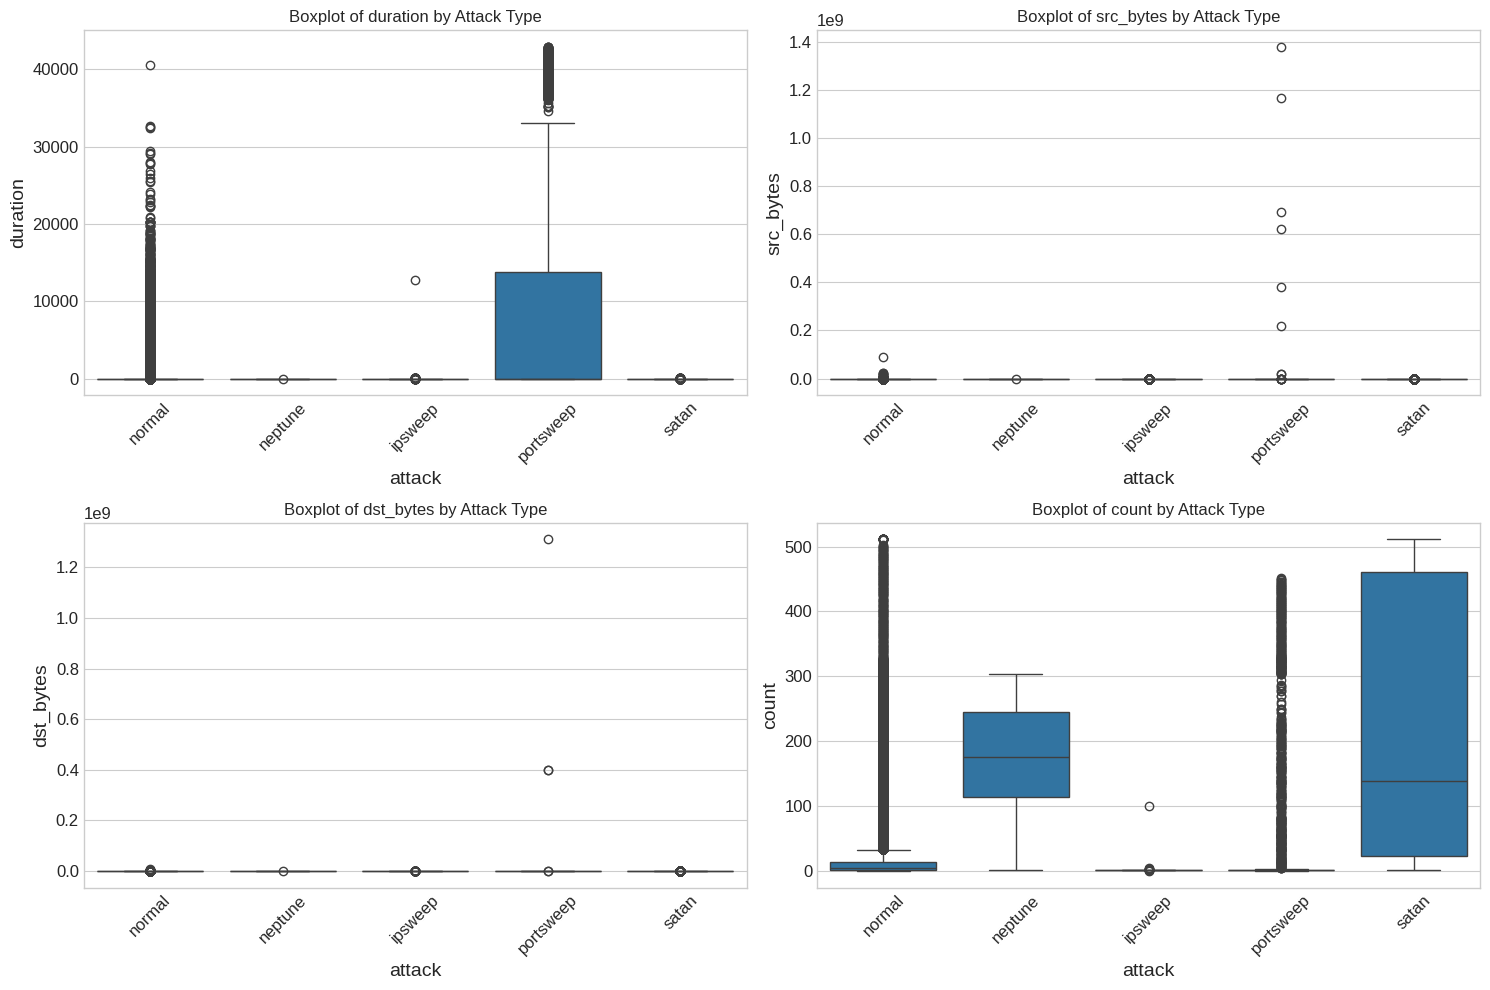

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['duration', 'src_bytes', 'dst_bytes', 'count']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='attack', y=feature, data=train_df[train_df['attack'].isin(['normal', 'neptune', 'satan', 'ipsweep', 'portsweep'])])
    plt.title(f'Boxplot of {feature} by Attack Type')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The following Bar plot show the distribution for top 10 features with 3 numerical features with the influence rate in each feature.

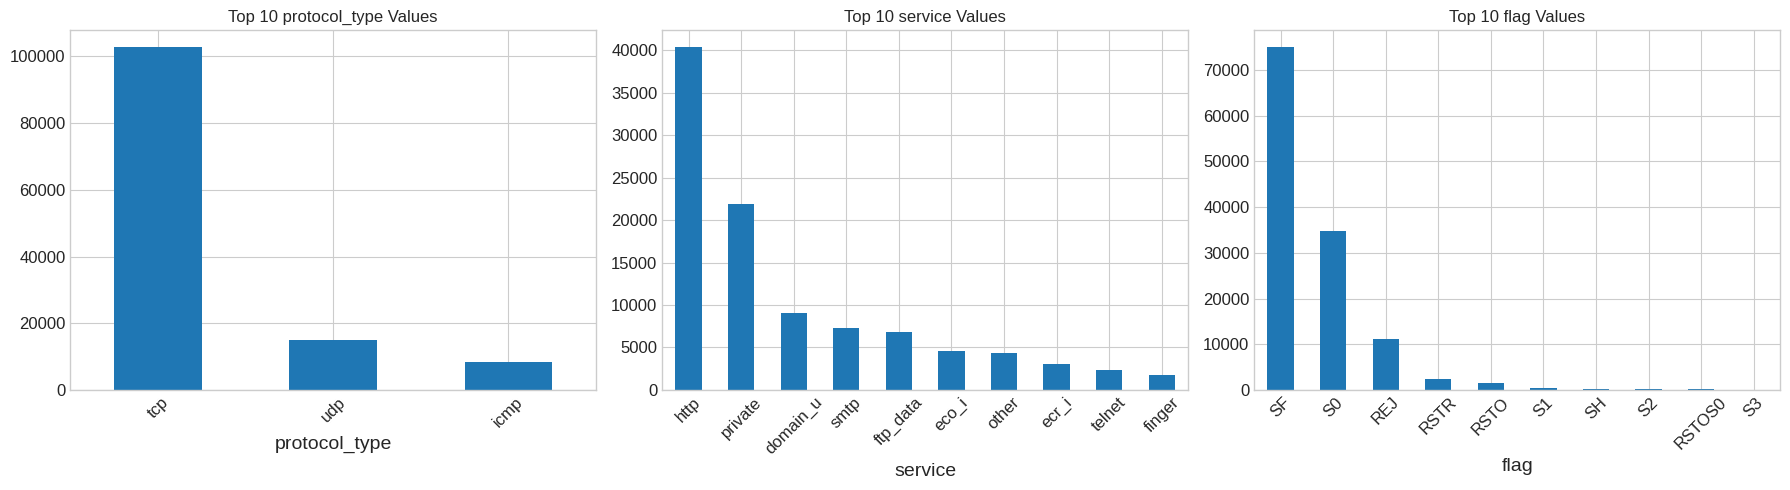

In [ ]:
cat_features = ['protocol_type', 'service', 'flag']
plt.figure(figsize=(18, 5))
for i, feature in enumerate(cat_features):
    plt.subplot(1, 3, i+1)
    train_df[feature].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {feature} Values')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
feature_groups = {
    'byte_features': ['src_bytes', 'dst_bytes'],
    'duration_features': ['duration'],
    'count_features': ['count', 'srv_count', 'dst_host_count', 'dst_host_srv_count'],
    'rate_features': [
        'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
    ],
    'binary_features': [
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
        'num_outbound_cmds', 'is_host_login', 'is_guest_login'
    ],
    'categorical_features': ['protocol_type', 'service', 'flag']
}


In [ ]:
byte_features = feature_groups['byte_features']
duration_features = feature_groups['duration_features']
count_features = feature_groups['count_features']
rate_features = feature_groups['rate_features']
binary_features = feature_groups['binary_features']
categorical_features = feature_groups['categorical_features']

# **3. Outlier Detection and Analysis**

In [ ]:
def detect_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

In [ ]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
print("\nOutliers in numerical features:")
for col in numerical_columns:
    outlier_count = detect_outlier(train_df, col)
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers")


Outliers in numerical features:
duration: 10018 outliers
src_bytes: 13840 outliers
dst_bytes: 23579 outliers
land: 25 outliers
wrong_fragment: 1090 outliers
urgent: 9 outliers
hot: 2671 outliers
num_failed_logins: 122 outliers
num_compromised: 1286 outliers
root_shell: 169 outliers
su_attempted: 80 outliers
num_root: 649 outliers
num_file_creations: 287 outliers
num_shells: 47 outliers
num_access_files: 371 outliers
is_host_login: 1 outliers
is_guest_login: 1187 outliers
count: 3157 outliers
srv_count: 12054 outliers
rerror_rate: 16190 outliers
srv_rerror_rate: 16206 outliers
diff_srv_rate: 7788 outliers
srv_diff_host_rate: 28399 outliers
dst_host_diff_srv_rate: 10550 outliers
dst_host_same_src_port_rate: 25052 outliers
dst_host_srv_diff_host_rate: 11682 outliers
dst_host_rerror_rate: 22795 outliers
dst_host_srv_rerror_rate: 19357 outliers
level: 2995 outliers


# **4. Data Preparation and Feature Engineering**

In [ ]:
train_copy_df = train_df.copy()
test_copy_df = test_df.copy()
train_idx = len(train_copy_df)
df_combined = pd.concat([train_copy_df, test_copy_df], axis=0)

In [ ]:
df_combined['binary_target'] = df_combined['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [ ]:
attack_categories = {
    'normal': 'normal',
    'neptune': 'dos', 'smurf': 'dos', 'pod': 'dos', 'teardrop': 'dos',
    'land': 'dos', 'back': 'dos', 'apache2': 'dos', 'udpstorm': 'dos',
    'processtable': 'dos', 'mailbomb': 'dos',
    'ipsweep': 'probe', 'portsweep': 'probe', 'nmap': 'probe', 'satan': 'probe',
    'mscan': 'probe', 'saint': 'probe',
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'xterm': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'httptunnel': 'u2r',
    'ftp_write': 'r2l', 'phf': 'r2l', 'guess_passwd': 'r2l', 'warezmaster': 'r2l',
    'warezclient': 'r2l', 'imap': 'r2l', 'spy': 'r2l', 'multihop': 'r2l',
    'named': 'r2l', 'snmpguess': 'r2l', 'worm': 'r2l', 'snmpgetattack': 'r2l',
    'xsnoop': 'r2l', 'xlock': 'r2l', 'sendmail': 'r2l'
}

df_combined['attack_category'] = df_combined['attack'].map(lambda x: attack_categories.get(x, 'unknown'))

In [ ]:
category_mapping = {cat: idx for idx, cat in enumerate(df_combined['attack_category'].unique())}
df_combined['attack_category_encoded'] = df_combined['attack_category'].map(category_mapping)

In [ ]:
print("\nAttack category distribution:")
print(df_combined['attack_category'].value_counts())


Attack category distribution:
attack_category
normal    77054
dos       53385
probe     14077
r2l        3749
u2r         252
Name: count, dtype: int64


The following Bar plot show the distribution for the attack category which includes top 5 columns( normal, dos, probe, r2I, u2r) and their count of occurrences for each category which help the understand the frequency for of attack types.

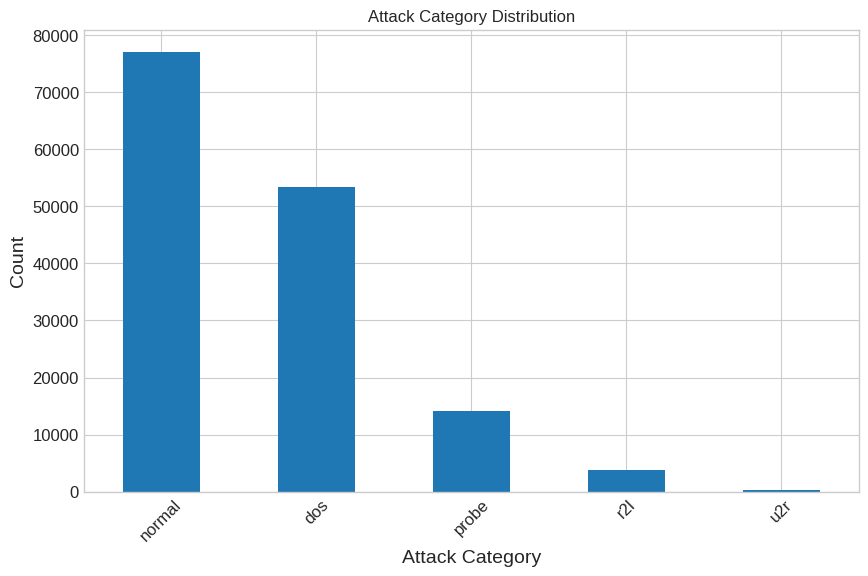

In [ ]:
plt.figure(figsize=(10, 6))
df_combined['attack_category'].value_counts().plot(kind='bar')
plt.title('Attack Category Distribution')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **5. Feature Transformation**

The log-scaled transformation used to visualize numerical features (duration, src_bytes, dst_bytes, count) which show the distribution for the original and after applying log-scaled transformation which appear how it decreased after applying the transformation.

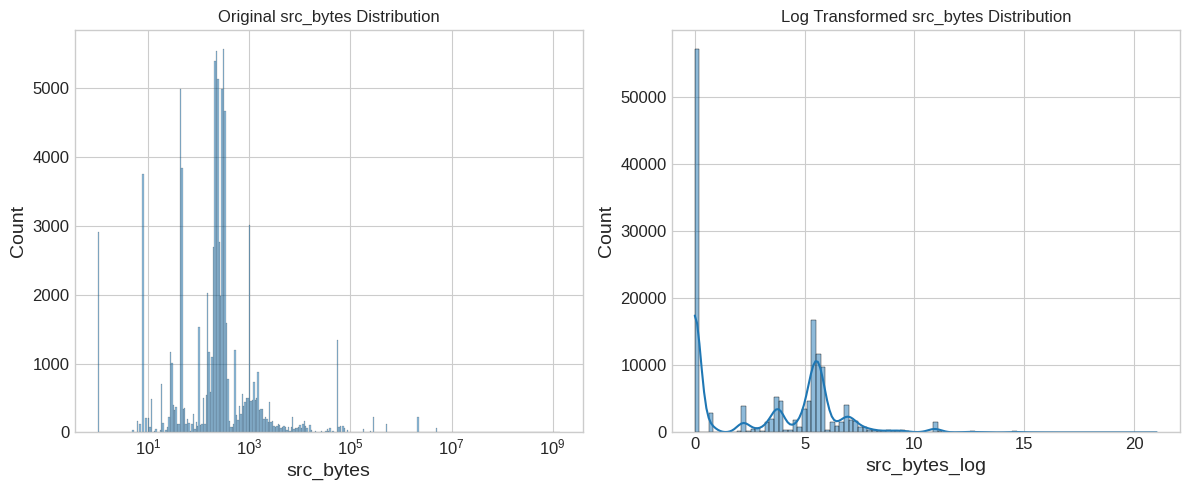

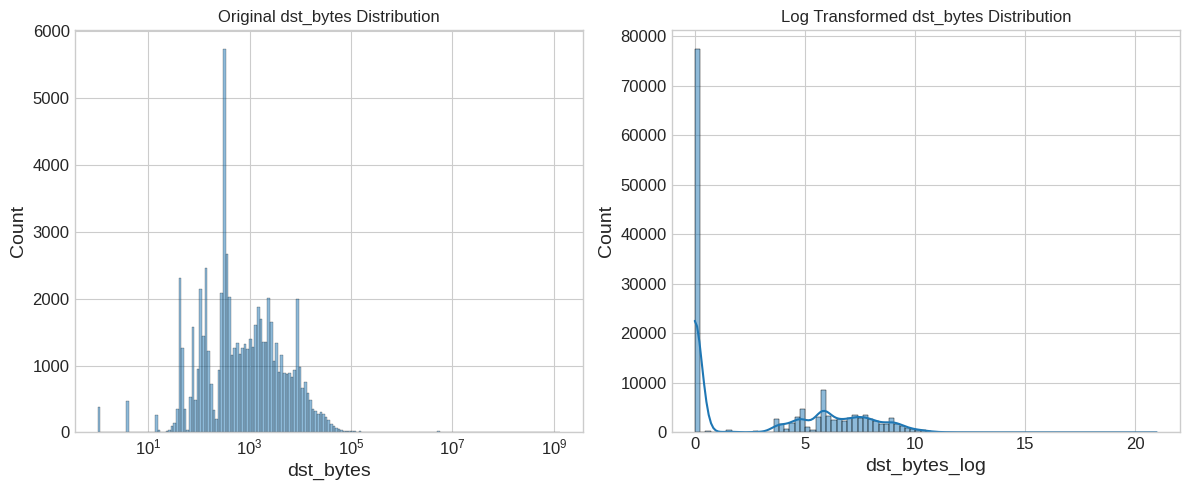

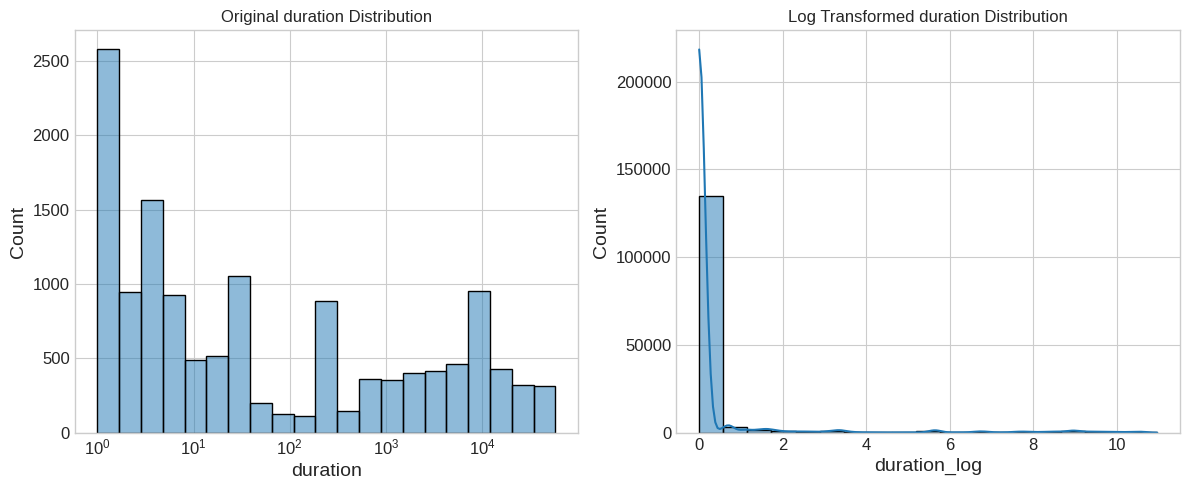

In [ ]:
for feature in byte_features + duration_features:
    df_combined[f'{feature}_log'] = np.log1p(df_combined[feature])

    # Plot original vs transformed distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_combined[feature], kde=True, log_scale=True)
    plt.title(f'Original {feature} Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(df_combined[f'{feature}_log'], kde=True)
    plt.title(f'Log Transformed {feature} Distribution')
    plt.tight_layout()
    plt.show()

In [ ]:
df_encoded = pd.get_dummies(df_combined, columns=categorical_features, drop_first=False)

In [ ]:
rate_scaler = RobustScaler()
rate_scaled = rate_scaler.fit_transform(df_encoded[rate_features])
rate_scaled_df = pd.DataFrame(
    rate_scaled,
    columns=[f'{col}_scaled' for col in rate_features],
    index=df_encoded.index
)

In [ ]:
count_scaler = RobustScaler()
count_scaled = count_scaler.fit_transform(df_encoded[count_features])
count_scaled_df = pd.DataFrame(
    count_scaled,
    columns=[f'{col}_scaled' for col in count_features],
    index=df_encoded.index
)

In [ ]:
df_processed = df_encoded.copy()
df_processed = pd.concat([df_processed, rate_scaled_df, count_scaled_df], axis=1)

# **6. Feature Selection and Importance**

In [ ]:
cols_to_drop = ['attack', 'level']
X = df_processed.drop(cols_to_drop + ['binary_target', 'attack_category', 'attack_category_encoded'], axis=1)

scaled_features = [col for col in X.columns if "_scaled" in col]
original_features_to_drop = [col.replace("_scaled", "") for col in scaled_features]

X_better = X.drop(columns=original_features_to_drop)

X_train = X_better.iloc[:train_idx]
X_test = X_better.iloc[train_idx:]


In [ ]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125973 entries, 0 to 125972
Columns: 125 entries, duration to dst_host_srv_count_scaled
dtypes: bool(84), float64(22), int64(19)
memory usage: 50.5 MB
<class 'pandas.core.frame.DataFrame'>
Index: 22544 entries, 0 to 22543
Columns: 125 entries, duration to dst_host_srv_count_scaled
dtypes: bool(84), float64(22), int64(19)
memory usage: 9.0 MB


In [ ]:
# Binary Classification Target
y_train_binary = df_processed['binary_target'].iloc[:train_idx]
y_test_binary = df_processed['binary_target'].iloc[train_idx:]

In [ ]:
# Multiclass classification targets
y_train_multi = df_processed['attack_category_encoded'].iloc[:train_idx]
y_test_multi = df_processed['attack_category_encoded'].iloc[train_idx:]

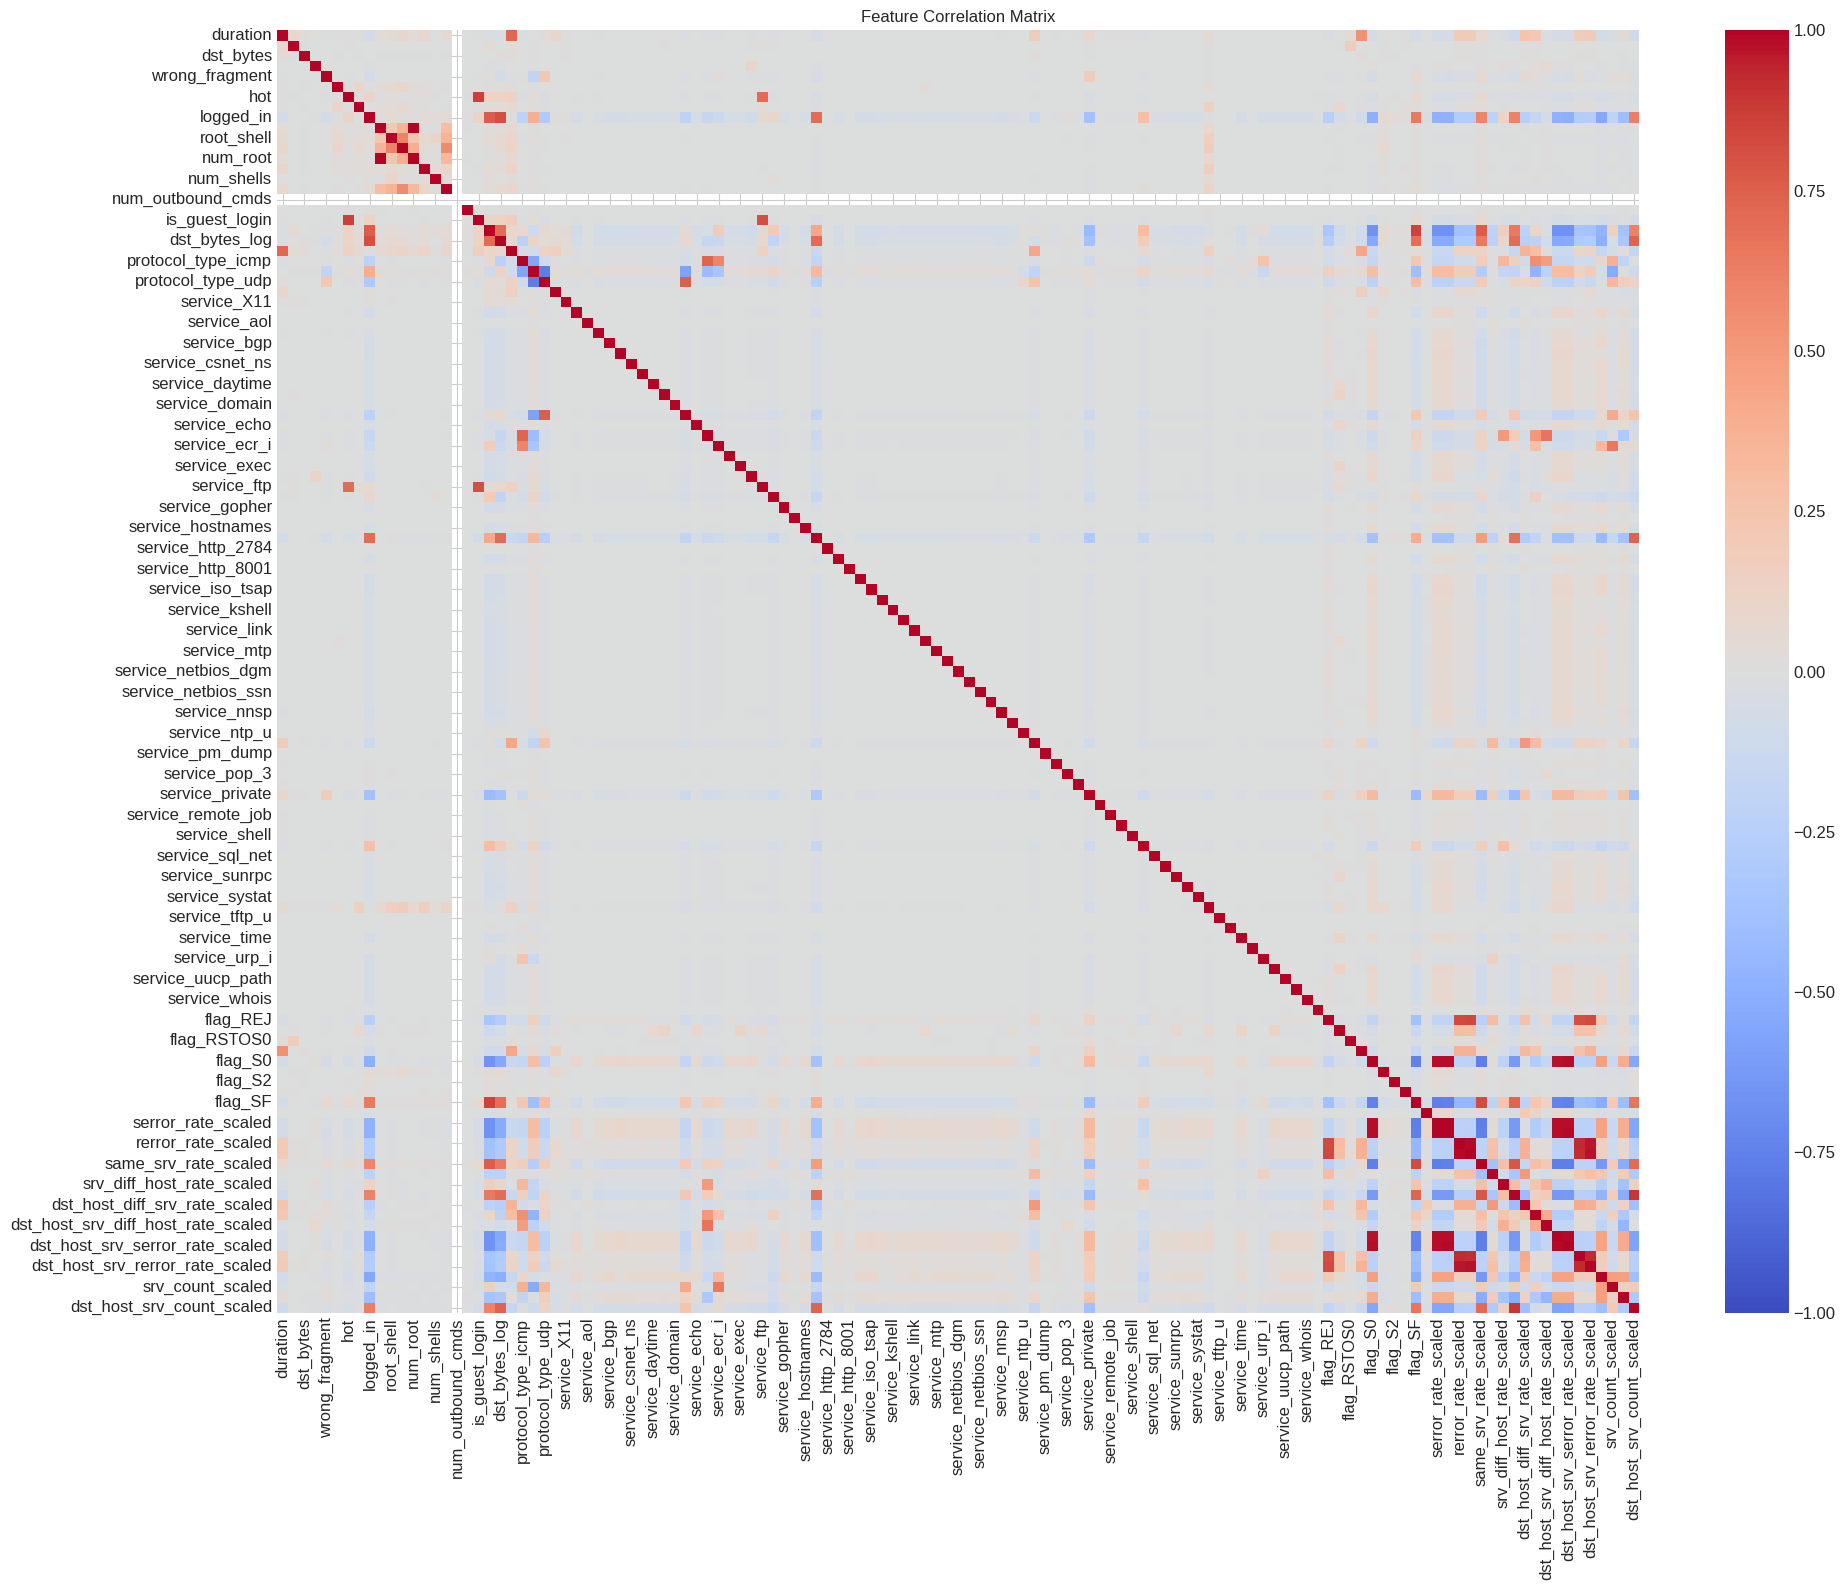

In [ ]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

1.   Redundant Features: Highly correlated features can introduce multicollinearity in models like logistic regression or linear classifiers. You might want to remove one of each such pair.
2.   Feature Selection: You can choose less correlated, more independent features for better generalization.
3. Model Performance: Reducing correlated inputs can improve interpretability and reduce overfitting.

In [ ]:
better_correlation_matrix = X_better.corr()

high_corr_threshold = 0.95
high_corr_features = set()

for i in range(len(better_correlation_matrix.columns)):
    for j in range(i):
        if abs(better_correlation_matrix.iloc[i, j]) > high_corr_threshold:
            feature_pair = (better_correlation_matrix.columns[i], better_correlation_matrix.columns[j])
            high_corr_features.add(feature_pair)

if high_corr_features:
    print("Highly correlated feature pairs (correlation > 0.95):")
    for feature1, feature2 in high_corr_features:
        corr_value = better_correlation_matrix.loc[feature1, feature2]
        print(f"{feature1} and {feature2}: {corr_value:.4f}")


Highly correlated feature pairs (correlation > 0.95):
srv_serror_rate_scaled and serror_rate_scaled: 0.9915
dst_host_srv_serror_rate_scaled and dst_host_serror_rate_scaled: 0.9828
srv_serror_rate_scaled and flag_S0: 0.9768
dst_host_serror_rate_scaled and serror_rate_scaled: 0.9747
dst_host_serror_rate_scaled and srv_serror_rate_scaled: 0.9708
dst_host_srv_serror_rate_scaled and flag_S0: 0.9755
serror_rate_scaled and flag_S0: 0.9727
dst_host_srv_rerror_rate_scaled and srv_rerror_rate_scaled: 0.9656
num_root and num_compromised: 0.9987
srv_rerror_rate_scaled and rerror_rate_scaled: 0.9861
dst_host_srv_rerror_rate_scaled and rerror_rate_scaled: 0.9574
dst_host_serror_rate_scaled and flag_S0: 0.9696
dst_host_srv_serror_rate_scaled and serror_rate_scaled: 0.9760
dst_host_srv_serror_rate_scaled and srv_serror_rate_scaled: 0.9820


In [ ]:
print("Performing ANOVA F-test for binary classification")
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_train, y_train_binary)
anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': anova_selector.scores_,
    'P_Value': anova_selector.pvalues_
})
anova_scores = anova_scores.sort_values('F_Score', ascending=False)


Performing ANOVA F-test for binary classification...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print("Top 20 features by ANOVA F-test (Binary Classification):")
print(anova_scores.head(20))


Top 20 features by ANOVA F-test (Binary Classification):
                             Feature        F_Score  P_Value
104                          flag_SF  168332.131565      0.0
20                     dst_bytes_log  164972.320416      0.0
110             same_srv_rate_scaled  163866.577206      0.0
19                     src_bytes_log  143274.967853      0.0
124        dst_host_srv_count_scaled  137598.286145      0.0
113    dst_host_same_srv_rate_scaled  116917.276744      0.0
8                          logged_in  114585.761111      0.0
118  dst_host_srv_serror_rate_scaled   94646.003539      0.0
117      dst_host_serror_rate_scaled   93069.951011      0.0
106               serror_rate_scaled   92481.504759      0.0
100                          flag_S0   92261.774118      0.0
107           srv_serror_rate_scaled   91324.684661      0.0
121                     count_scaled   62689.677518      0.0
49                      service_http   58249.601370      0.0
74                   servic

1-dst_bytes_log / src_bytes_log: How much data was sent or received — usually very different in attack vs. normal.

2-same_srv_rate_scaled, srv_rate_scaled: How frequently the same service was used — DoS attacks often have repetitive service requests.

3-flag_SF: TCP connection status — may vary strongly between legitimate and attack traffic.

4-logged_in: Binary indicator of successful login — often 0 in attack records like R2L and U2R.

5-Host- and destination-related rates like: dst_host_srv_count_scaled dst_host_same_srv_rate_scaled

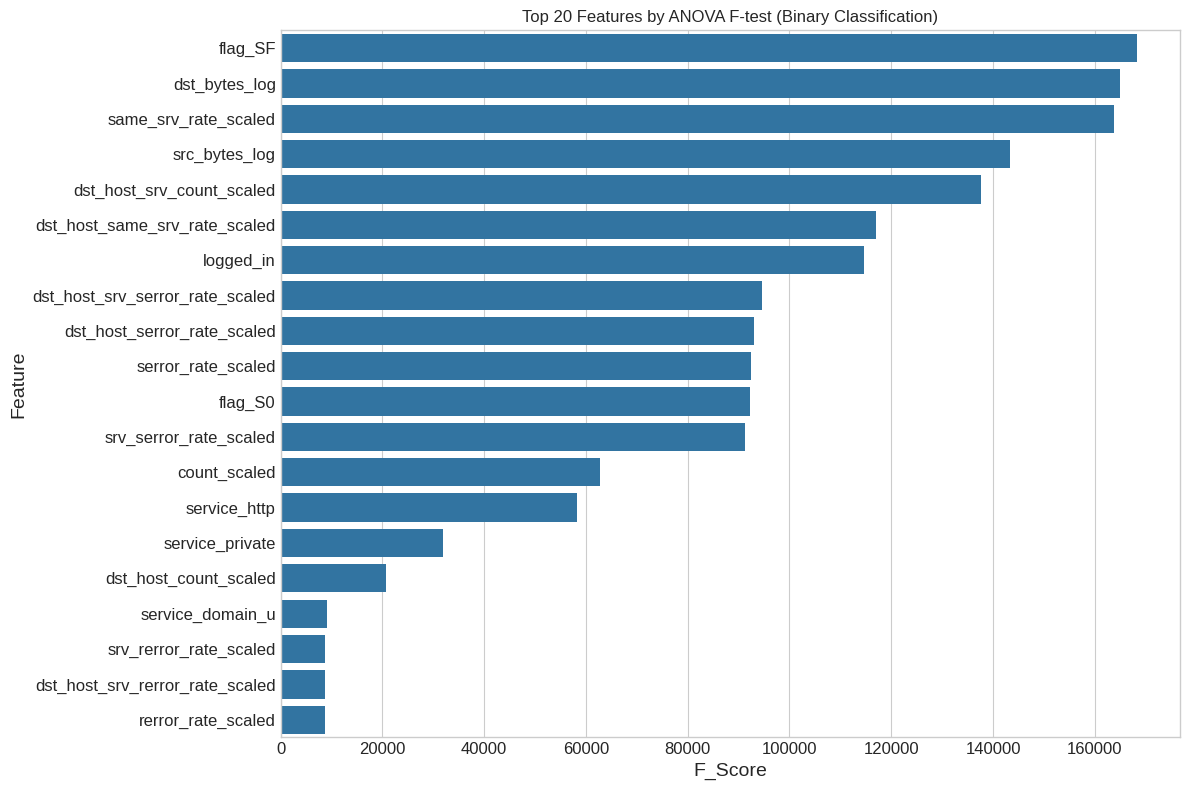

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='F_Score', y='Feature', data=anova_scores.head(20))
plt.title('Top 20 Features by ANOVA F-test (Binary Classification)')
plt.tight_layout()
plt.show()

# **7. Model Training - Binary Classification**

In [ ]:
print("Applying SMOTE for binary classification")
print(f"Class distribution before SMOTE: {pd.Series(y_train_binary).value_counts()}")


Applying SMOTE for binary classification...
Class distribution before SMOTE: binary_target
0    67343
1    58630
Name: count, dtype: int64


In [ ]:
smote_binary = SMOTE(random_state=42)
X_train_binary_smote, y_train_binary_smote = smote_binary.fit_resample(X_train, y_train_binary)
print(f"Class distribution after SMOTE: {pd.Series(y_train_binary_smote).value_counts()}")

Class distribution after SMOTE: binary_target
0    67343
1    67343
Name: count, dtype: int64




1.  Before SMOTE:

Class 1 (Attack) has significantly more samples than Class 0 (Normal).
This imbalance can bias the model — making it predict the majority class more often.
2. After SMOTE:

Both classes (0 and 1) have roughly equal heights in the bar chart.
This means the dataset is now balanced and better suited for training.
  



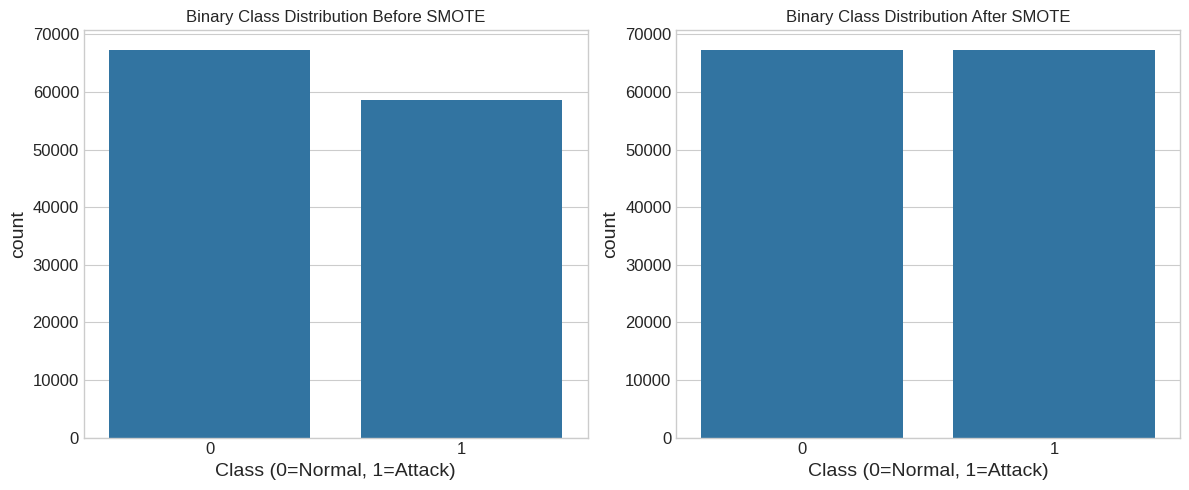

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_binary)
plt.title('Binary Class Distribution Before SMOTE')
plt.xlabel('Class (0=Normal, 1=Attack)')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_binary_smote)
plt.title('Binary Class Distribution After SMOTE')
plt.xlabel('Class (0=Normal, 1=Attack)')
plt.tight_layout()
plt.show()

In [ ]:
print("Training Random Forest for binary classification")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_binary_smote, y_train_binary_smote)


Training Random Forest for binary classification...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Evaluate the model
y_pred_binary = rf.predict(X_test)
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Binary classification accuracy: {binary_accuracy:.4f}")

Binary classification accuracy: 0.7832


In [ ]:
print("Classification Report (Binary):")
print(classification_report(y_test_binary, y_pred_binary))


Classification Report (Binary):
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544





1.   True Negatives (TN = 9449): Normal traffic correctly predicted as Normal
2. False Positives (FP = 262): Normal traffic incorrectly predicted as Attack (False Alarm)
3. False Negatives (FN = 4625): Attack traffic missed and predicted as Normal
4. True Positives (TP = 8208): Attack traffic correctly predicted as Attack
  



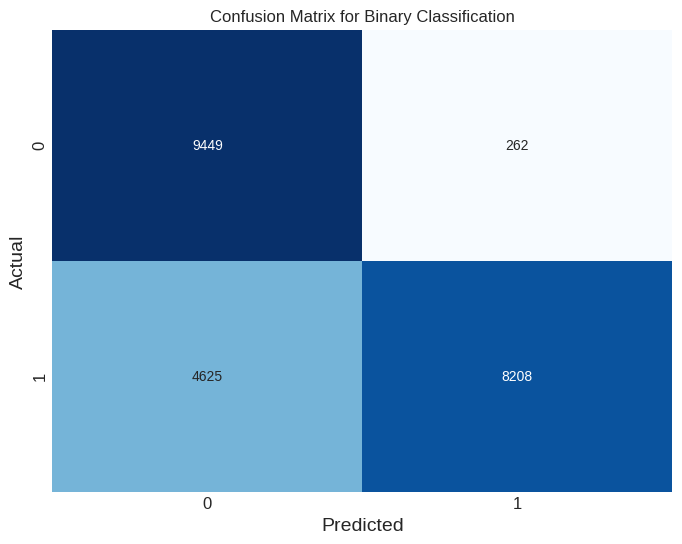

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Feature importance indicates how valuable each feature was in making predictions. In Random Forests, this is typically measured by how much each feature decreases impurity (e.g., Gini index or entropy) across all trees.


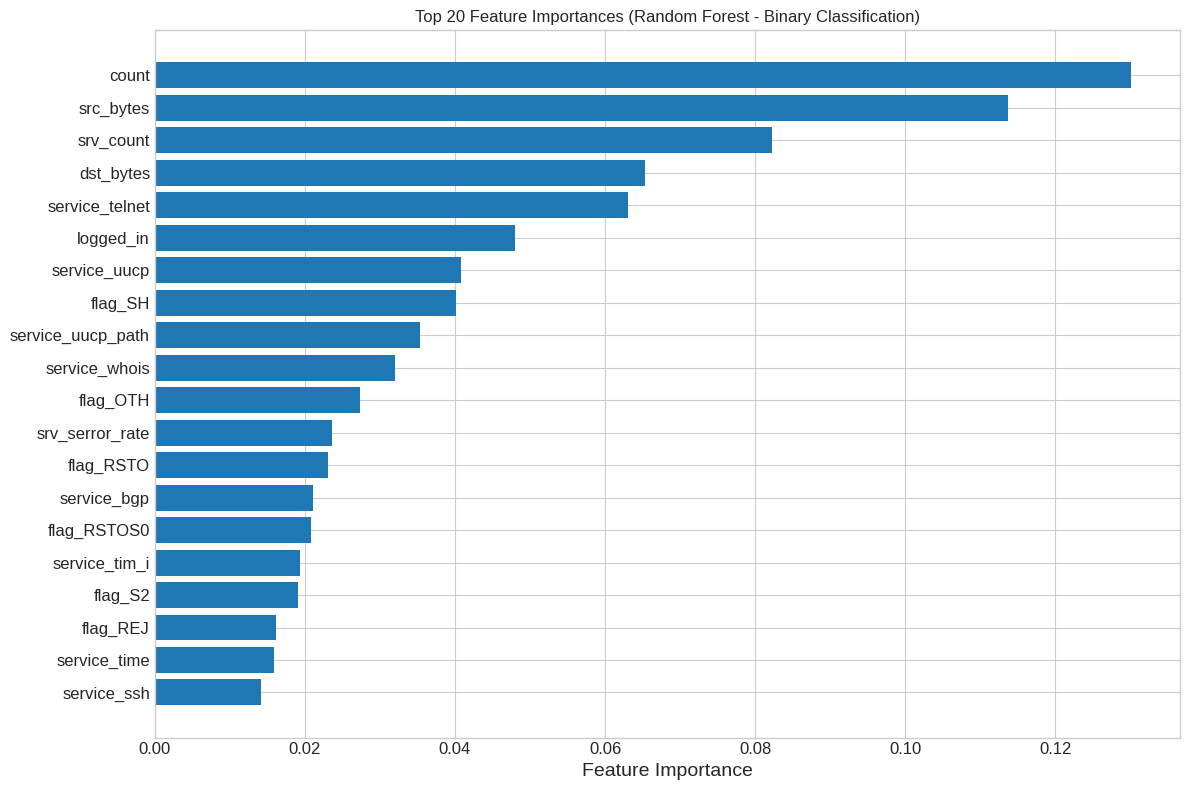

In [ ]:
plt.figure(figsize=(12, 8))
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest - Binary Classification)')
plt.tight_layout()
plt.show()

# **8. Model Training - Multiclass Classification**

In [ ]:
print("\nApplying SMOTE for multiclass classification...")
attack_category_labels = {v: k for k, v in category_mapping.items()}
print(f"Class distribution before SMOTE: {pd.Series(y_train_multi).map(attack_category_labels).value_counts()}")
smote_multi = SMOTE(random_state=42)
X_train_multi_smote, y_train_multi_smote = smote_multi.fit_resample(X_train, y_train_multi)
print(f"Class distribution after SMOTE: {pd.Series(y_train_multi_smote).map(attack_category_labels).value_counts()}")


Applying SMOTE for multiclass classification...
Class distribution before SMOTE: attack_category_encoded
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64
Class distribution after SMOTE: attack_category_encoded
normal    67343
dos       67343
r2l       67343
probe     67343
u2r       67343
Name: count, dtype: int64


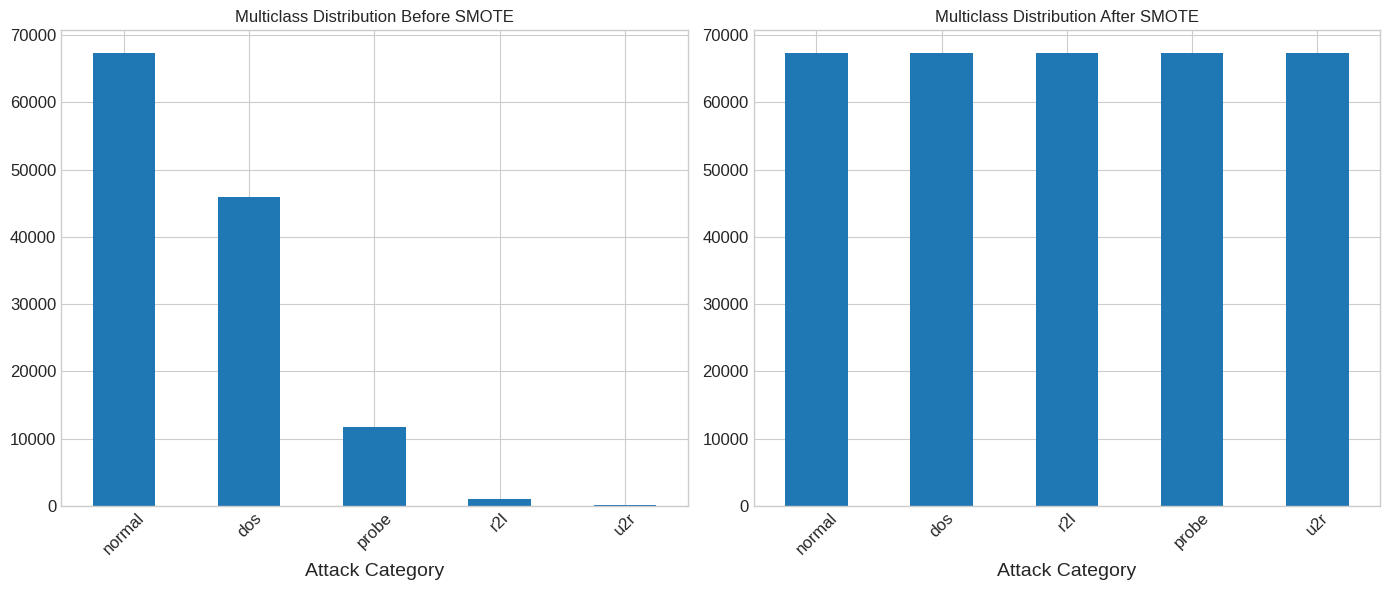

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
pd.Series(y_train_multi).map(attack_category_labels).value_counts().plot(kind='bar')
plt.title('Multiclass Distribution Before SMOTE')
plt.xlabel('Attack Category')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_train_multi_smote).map(attack_category_labels).value_counts().plot(kind='bar')
plt.title('Multiclass Distribution After SMOTE')
plt.xlabel('Attack Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
for idx, category in attack_category_labels.items():
    print(f"{idx}: {category}")


Attack category mapping:
0: normal
1: dos
2: r2l
3: probe
4: u2r


In [ ]:
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_multi.fit(X_train_multi_smote, y_train_multi_smote)


Training Random Forest for multiclass classification...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred_multi = rf_multi.predict(X_test)
multi_accuracy = accuracy_score(y_test_multi, y_pred_multi)
print(f"Multiclass classification accuracy: {multi_accuracy:.4f}")

Multiclass classification accuracy: 0.7521


In [ ]:
print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multi, y_pred_multi,
                         target_names=list(attack_category_labels.values())))


Classification Report (Multiclass):
              precision    recall  f1-score   support

      normal       0.65      0.97      0.78      9711
         dos       0.96      0.77      0.85      7458
         r2l       0.95      0.06      0.12      2754
       probe       0.82      0.67      0.74      2421
         u2r       0.73      0.04      0.08       200

    accuracy                           0.75     22544
   macro avg       0.82      0.50      0.51     22544
weighted avg       0.81      0.75      0.71     22544



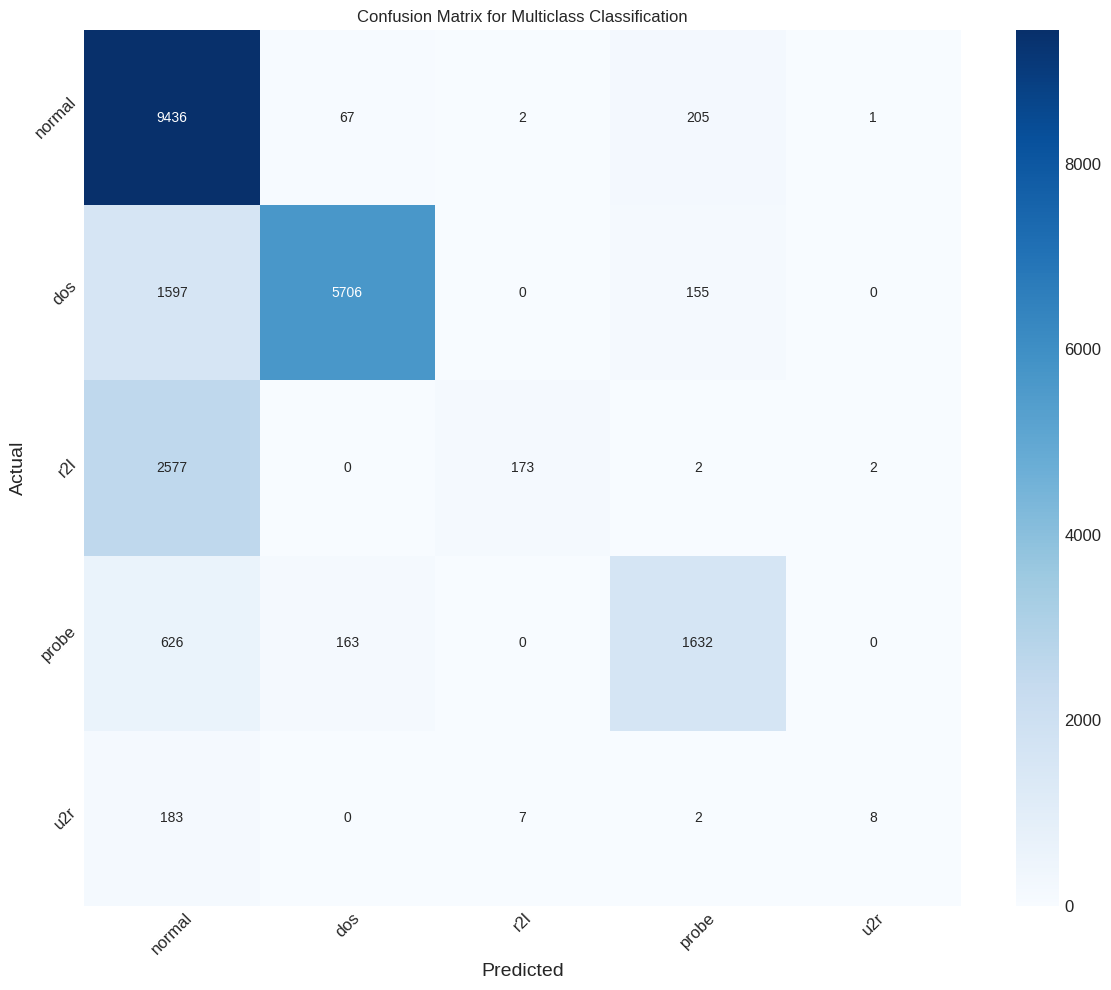

In [ ]:
plt.figure(figsize=(12, 10))
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', xticklabels=list(attack_category_labels.values()),
           yticklabels=list(attack_category_labels.values()))
plt.title('Confusion Matrix for Multiclass Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

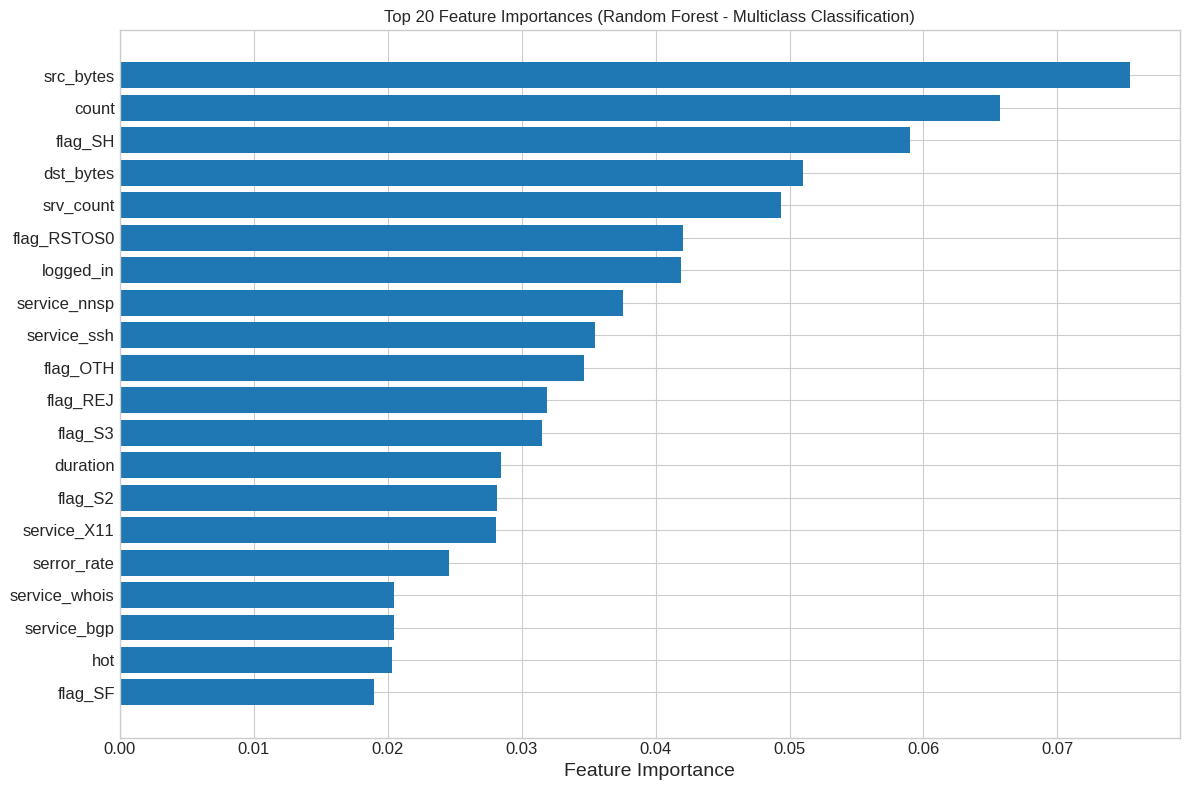

In [ ]:
plt.figure(figsize=(12, 8))
importances_multi = rf_multi.feature_importances_
indices_multi = np.argsort(importances_multi)[-20:]  # Top 20 features
plt.barh(range(len(indices_multi)), importances_multi[indices_multi])
plt.yticks(range(len(indices_multi)), [X.columns[i] for i in indices_multi])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest - Multiclass Classification)')
plt.tight_layout()
plt.show()

# **9. Mutual Information Analysis**

In [ ]:
mi_binary = mutual_info_classif(X_train, y_train_binary, random_state=42)
mi_binary_dict = dict(zip(X_train.columns, mi_binary))
sorted_mi_binary = sorted(mi_binary_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
mi_multi = mutual_info_classif(X_train, y_train_multi, random_state=42)
mi_multi_dict = dict(zip(X_train.columns, mi_multi))
sorted_mi_multi = sorted(mi_multi_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print("Top 20 features by (Multiclass Classification):")
for i, (feature, score) in enumerate(sorted_mi_multi[:20]):
    print(f"{i+1}. {feature}: {score:.6f}")


Top 20 features by mutual_info_classif (Multiclass Classification):
1. src_bytes_log: 0.716950
2. src_bytes: 0.716633
3. diff_srv_rate_scaled: 0.508853
4. dst_bytes_log: 0.461060
5. dst_bytes: 0.460962
6. same_srv_rate_scaled: 0.457237
7. dst_host_diff_srv_rate_scaled: 0.450261
8. dst_host_srv_count_scaled: 0.418446
9. count_scaled: 0.411534
10. dst_host_serror_rate_scaled: 0.402287
11. dst_host_same_srv_rate_scaled: 0.400795
12. flag_SF: 0.387702
13. serror_rate_scaled: 0.386563
14. dst_host_srv_serror_rate_scaled: 0.378588
15. flag_S0: 0.365215
16. srv_serror_rate_scaled: 0.363621
17. logged_in: 0.316802
18. dst_host_srv_diff_host_rate_scaled: 0.260539
19. dst_host_same_src_port_rate_scaled: 0.233224
20. dst_host_count_scaled: 0.205921


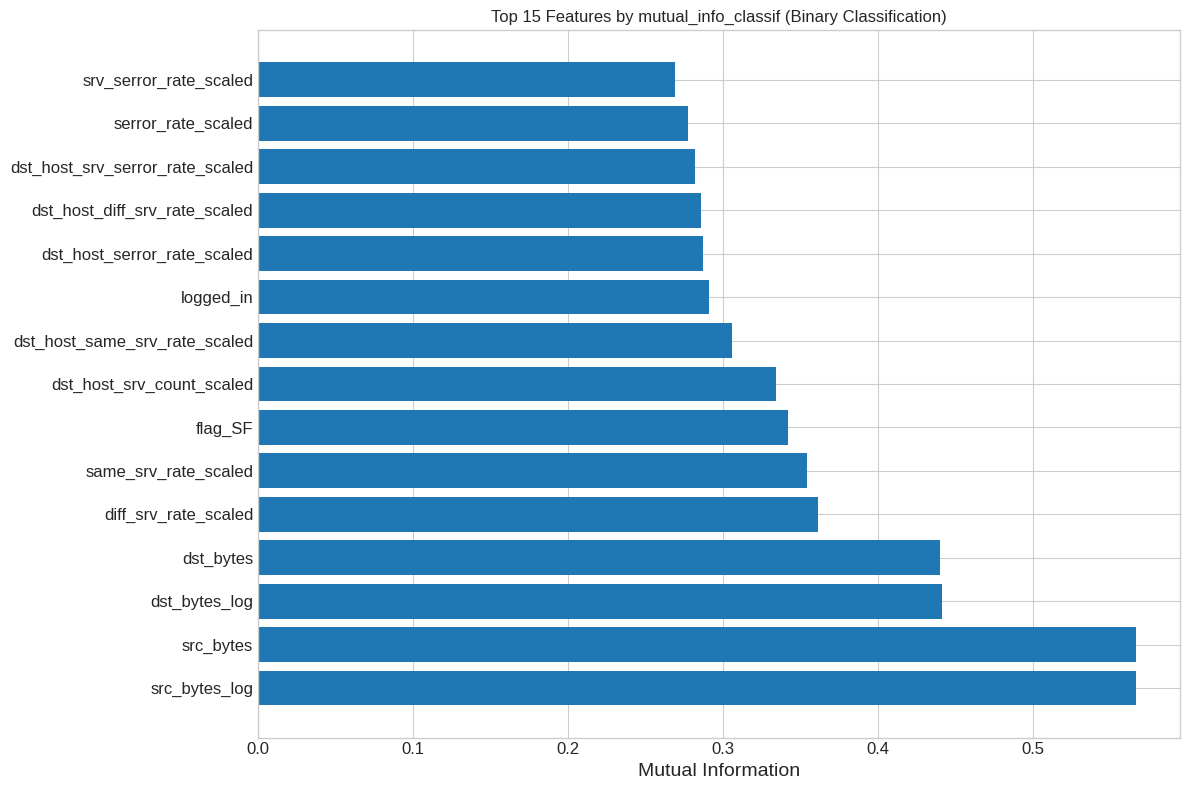

In [ ]:
plt.figure(figsize=(12, 8))
features_mi = [feature for feature, _ in sorted_mi_binary[:15]]
values_mi = [score for _, score in sorted_mi_binary[:15]]
plt.barh(range(len(features_mi)), values_mi)
plt.yticks(range(len(features_mi)), features_mi)
plt.xlabel('Mutual Information')
plt.title('Top 15 Features by mutual_info_classif (Binary Classification)')
plt.tight_layout()
plt.show()

In [ ]:
rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

n_features_to_select = 20
rfe_binary = RFE(estimator=rf_rfe, step=1)

rfe_binary.fit(X_train_binary_smote, y_train_binary_smote)

selected_features_rfe_binary = X_train.columns[rfe_binary.support_].tolist()
feature_ranking_binary = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': rfe_binary.ranking_,
    'Selected': rfe_binary.support_
}).sort_values(by='Ranking')

<Figure size 1000x600 with 0 Axes>

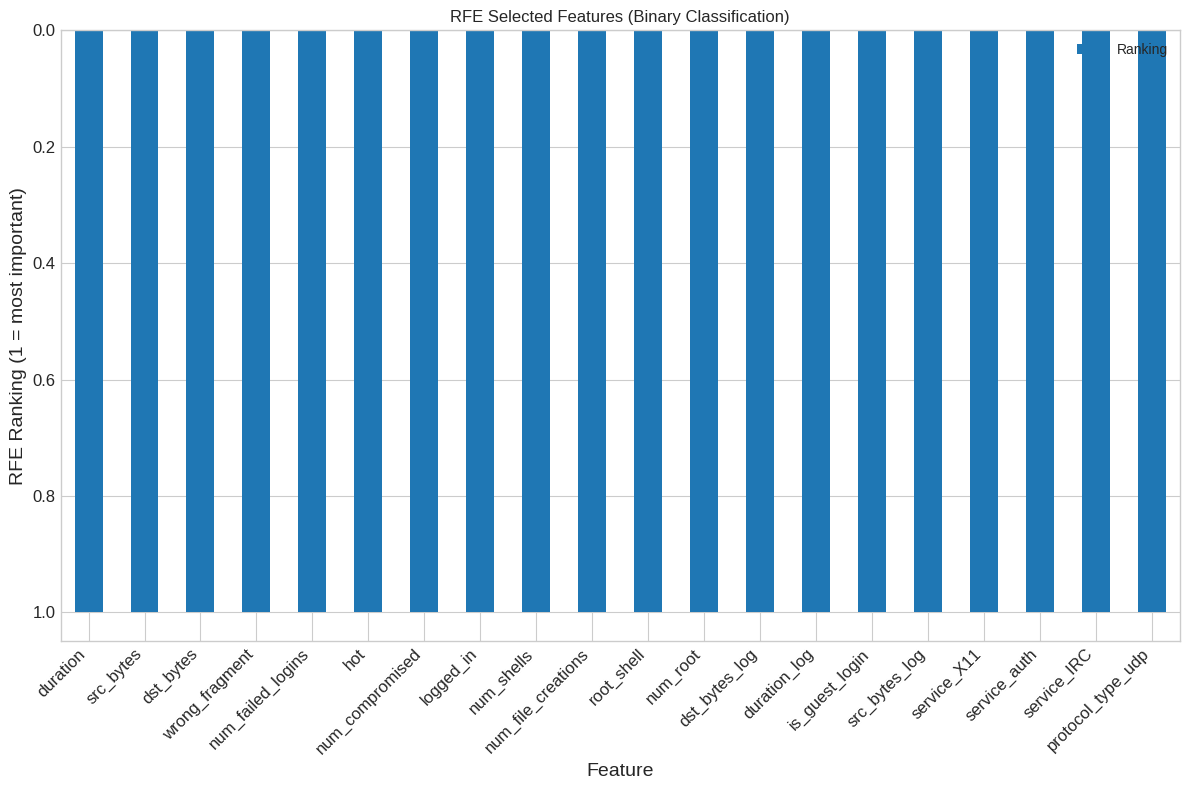

In [ ]:
plt.figure(figsize=(10, 6))
feature_ranking_binary[feature_ranking_binary['Selected']].head(20).plot(
    x='Feature',
    y='Ranking',
    kind='bar',
    color='#1f77b4'
)
plt.title('RFE Selected Features (Binary Classification)')
plt.xlabel('Feature')
plt.ylabel('RFE Ranking (1 = most important)')
plt.gca().invert_yaxis()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
X_train_rfe_binary = rfe_binary.transform(X_train_binary_smote)
X_test_rfe_binary = rfe_binary.transform(X_test)

rf_rfe_binary = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_rfe_binary.fit(X_train_rfe_binary, y_train_binary_smote)
y_pred_rfe_binary = rf_rfe_binary.predict(X_test_rfe_binary)


Binary classification accuracy with RFE-selected features: 0.7617
Original accuracy: 0.7832


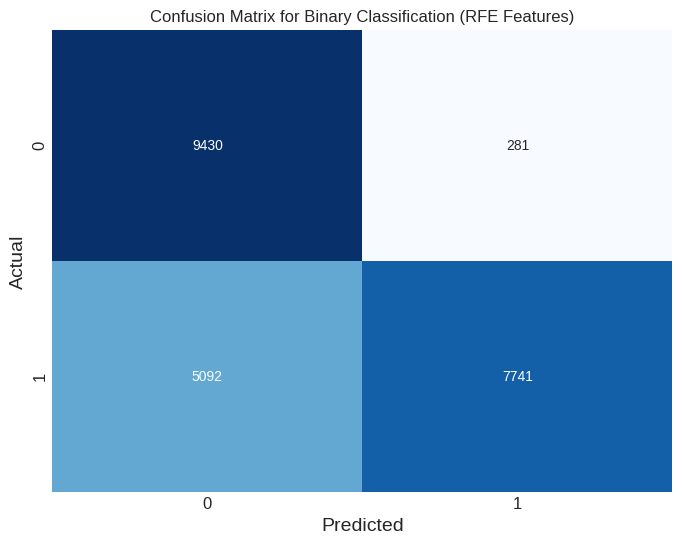

In [ ]:
accuracy_rfe_binary = accuracy_score(y_test_binary, y_pred_rfe_binary)
print(f"Binary classification accuracy with RFE-selected features: {accuracy_rfe_binary:.4f}")
print("Original accuracy: {:.4f}".format(binary_accuracy))

plt.figure(figsize=(8, 6))
cm_rfe_binary = confusion_matrix(y_test_binary, y_pred_rfe_binary)
sns.heatmap(cm_rfe_binary, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Binary Classification (RFE Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
rf_explainer = shap.TreeExplainer(rf_rfe_binary)
sample_size = min(500, X_test_rfe_binary.shape[0])
X_test_rf_sample = X_test_rfe_binary[:sample_size]

In [ ]:
rf_shap_values = rf_explainer.shap_values(X_test_rf_sample)
if isinstance(rf_shap_values, list):
    rf_shap_values = rf_shap_values[1]

<Figure size 1200x800 with 0 Axes>

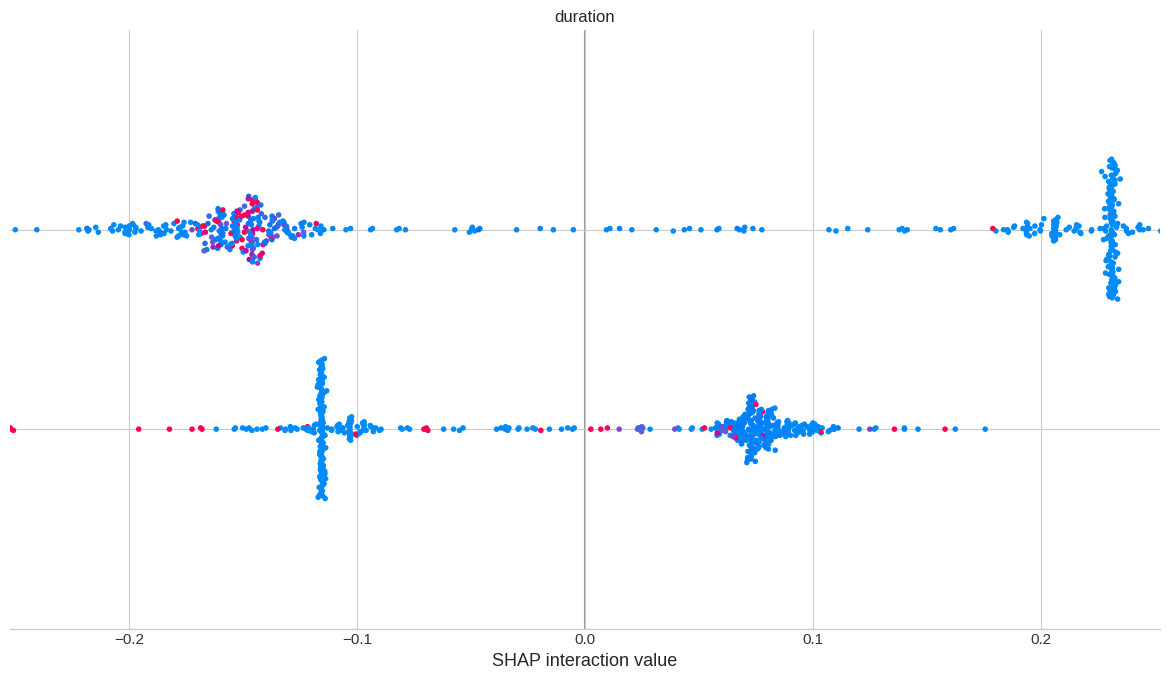

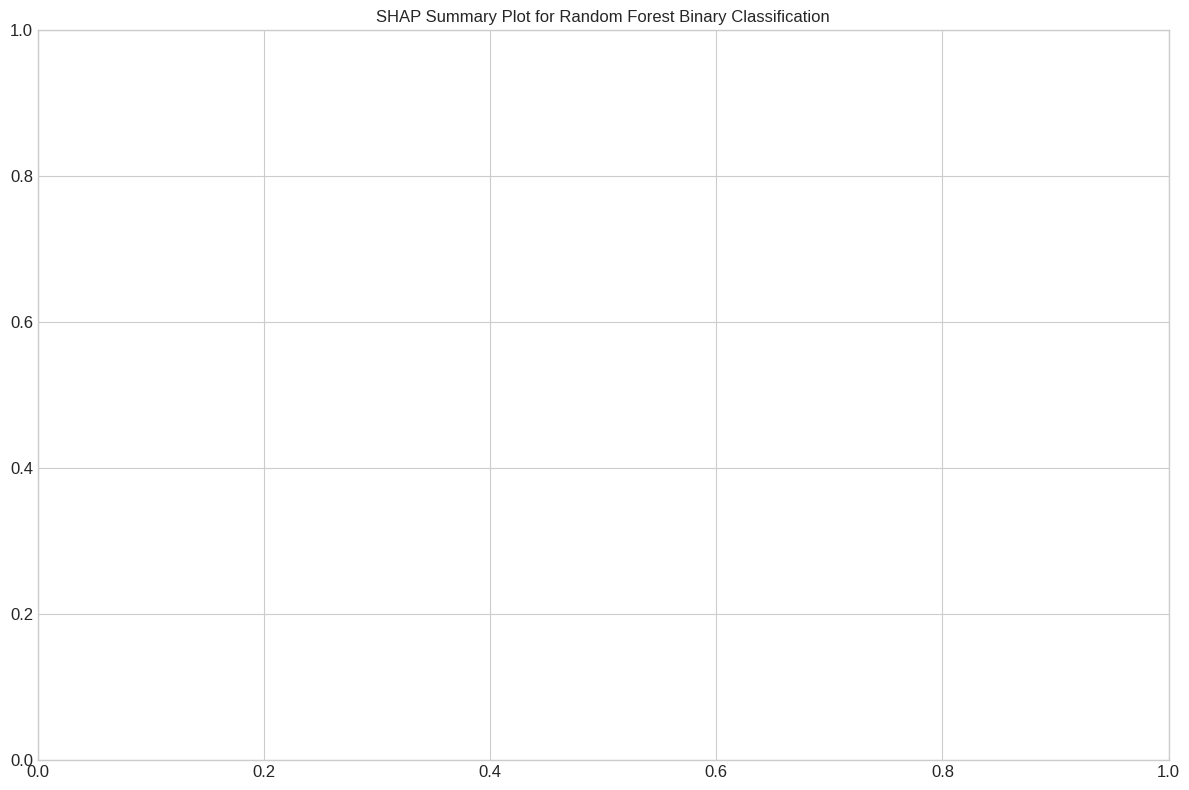

In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(rf_shap_values, X_test_rf_sample, feature_names=selected_features_rfe_binary)
plt.title('SHAP Summary Plot for Random Forest Binary Classification')
plt.tight_layout()
plt.show()

In [ ]:
lime_rf_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_rfe_binary,
    feature_names=selected_features_rfe_binary,
    class_names=['Normal', 'Attack'],
    mode='classification'
)


In [ ]:
rf_correct_predictions = np.where(y_test_binary == y_pred_rfe_binary)[0]
if len(rf_correct_predictions) > 0:
    rf_instance_idx = rf_correct_predictions[0]
else:
    rf_instance_idx = 0

rf_lime_exp = lime_rf_explainer.explain_instance(
    X_test_rfe_binary[rf_instance_idx],
    rf_rfe_binary.predict_proba,
    num_features=10
)

<Figure size 1000x600 with 0 Axes>

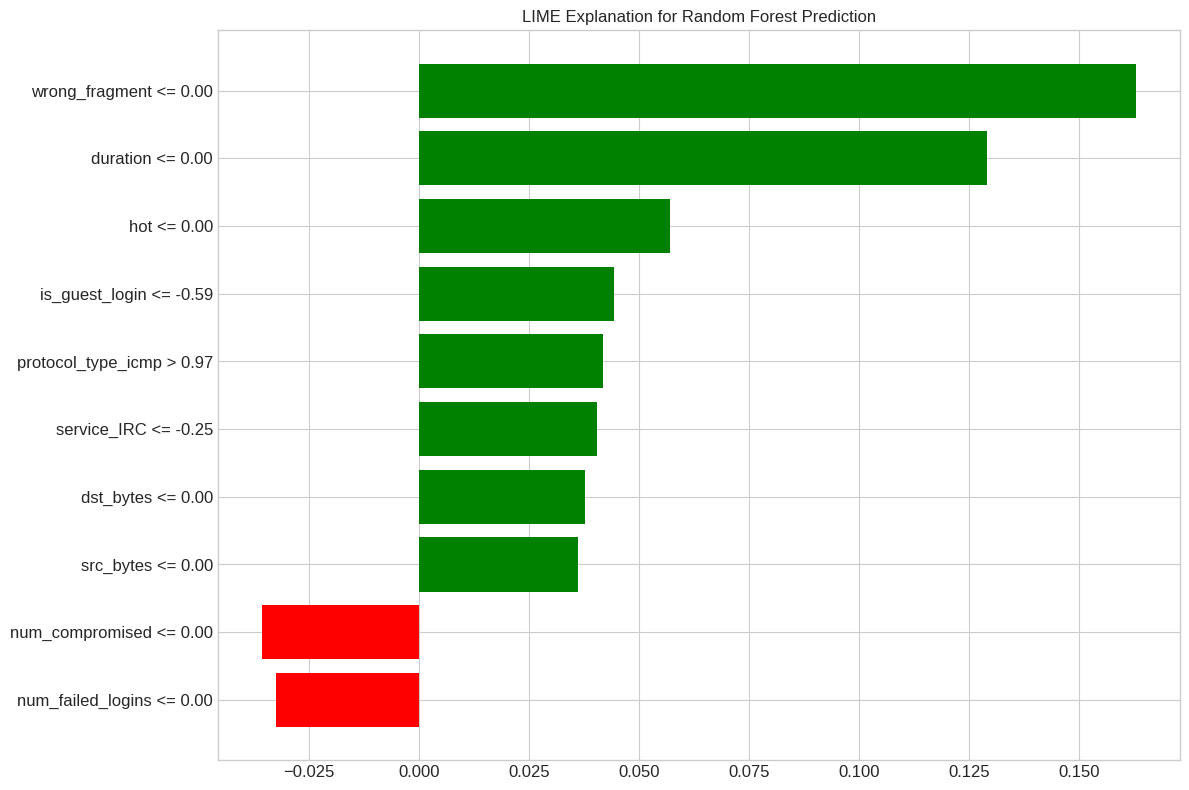

In [ ]:
plt.figure(figsize=(10, 6))
rf_lime_exp.as_pyplot_figure()
plt.title('LIME Explanation for Random Forest Prediction')
plt.tight_layout()
plt.show()

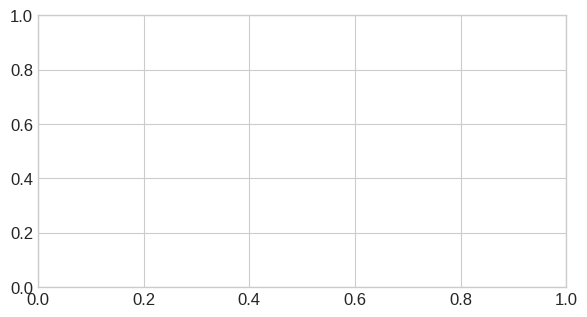

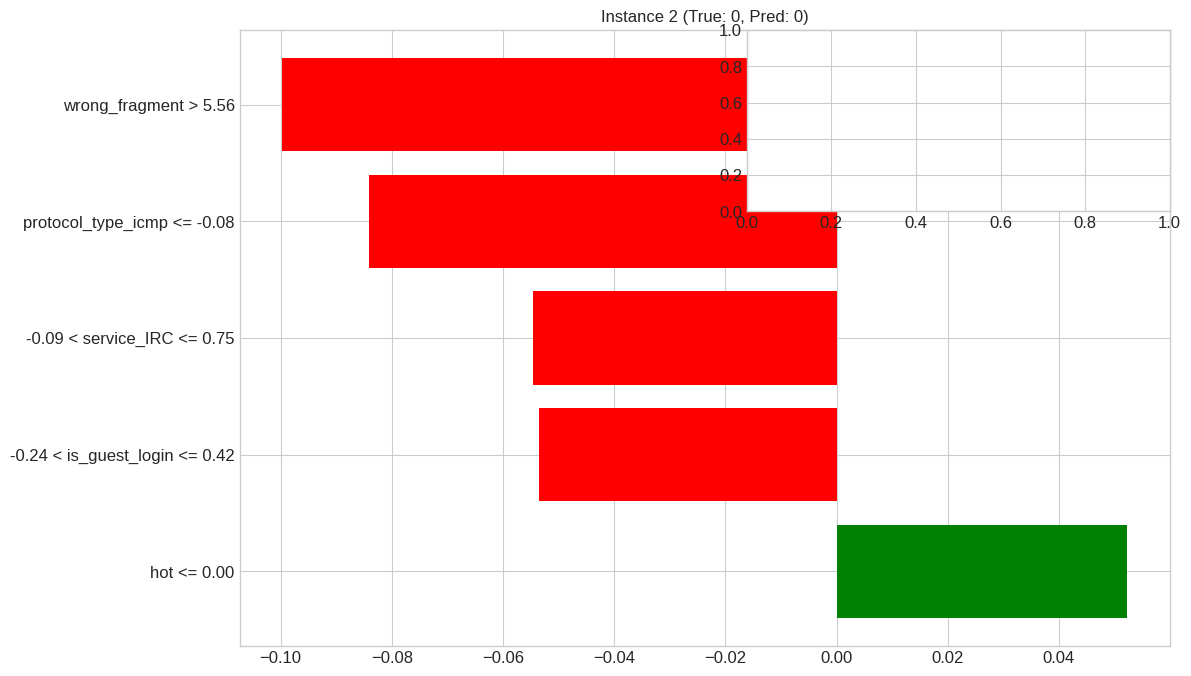

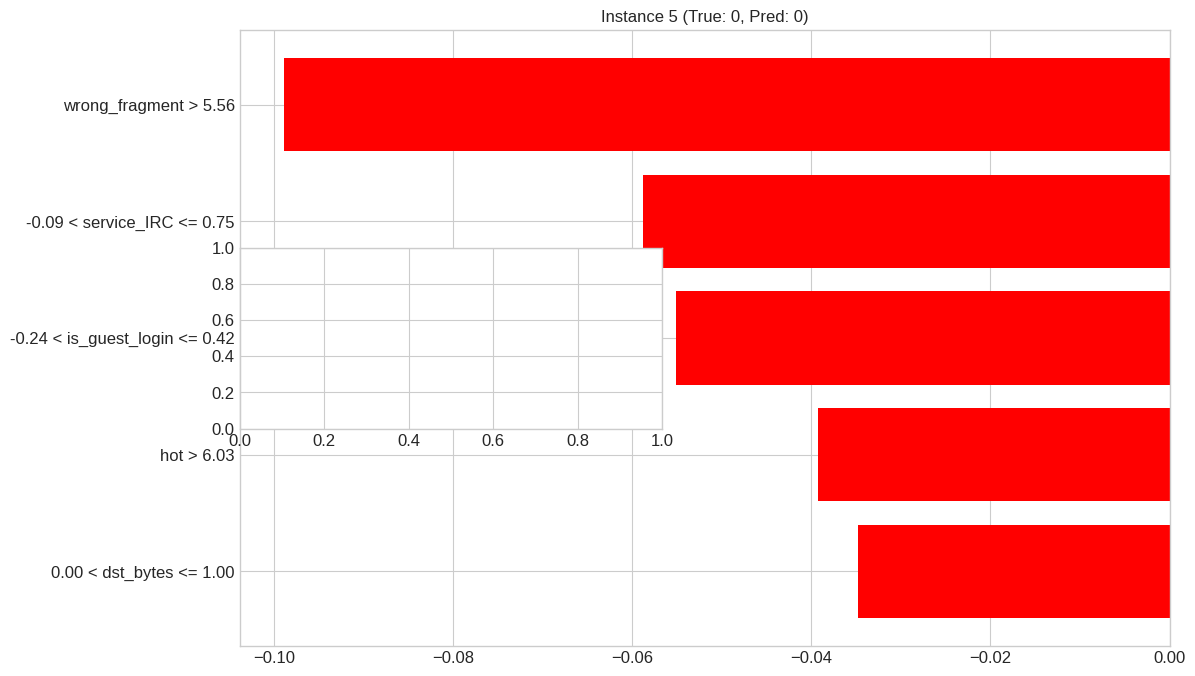

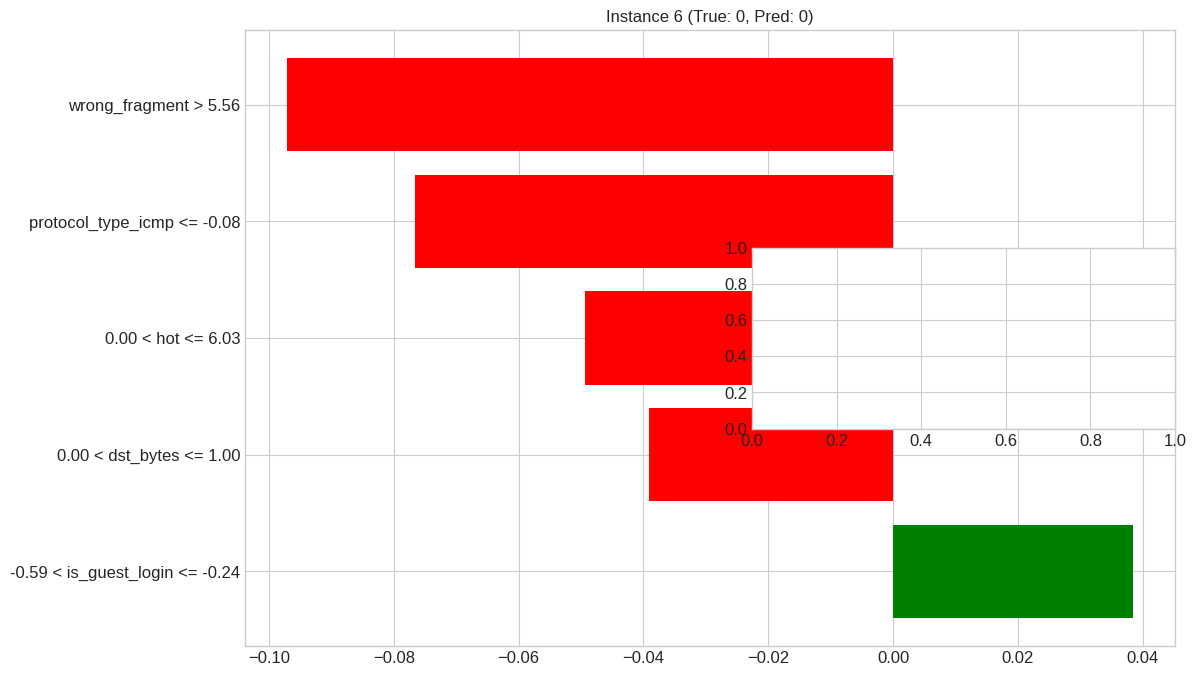

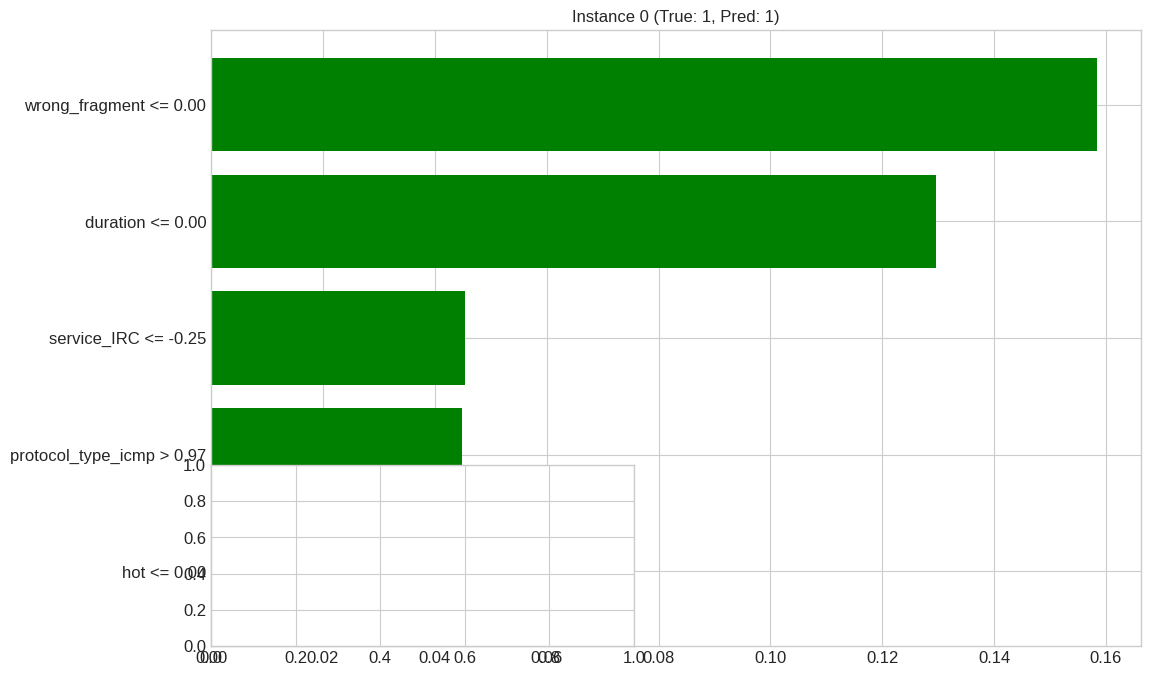

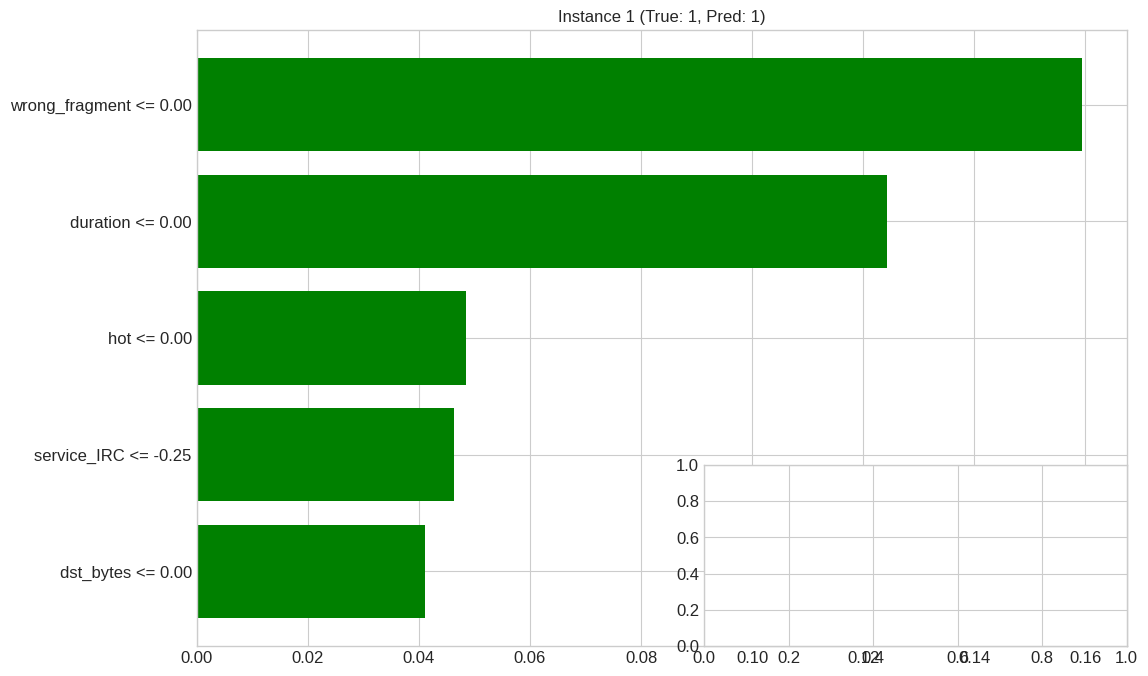

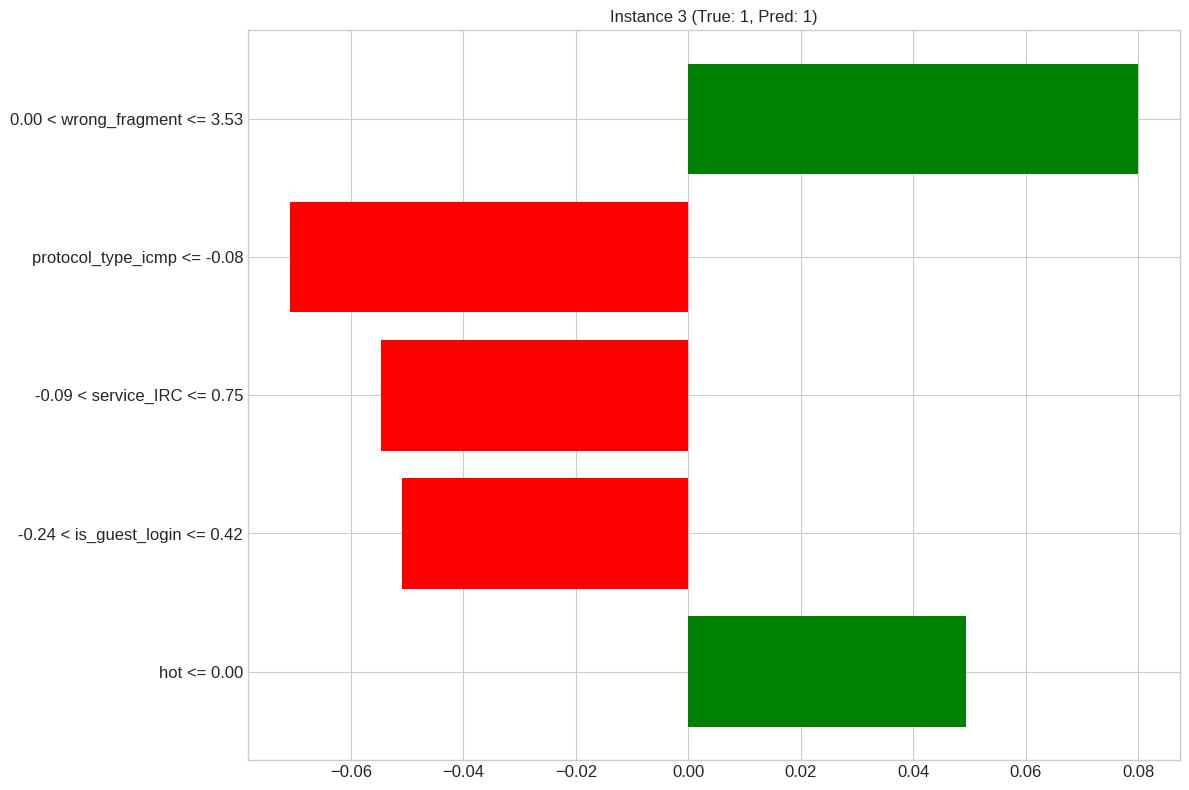

In [ ]:
rf_test_instances = np.concatenate([normal_instances, attack_instances])
plt.figure(figsize=(15, 12))
for i, idx in enumerate(rf_test_instances):
    plt.subplot(3, 2, i+1)
    rf_instance_exp = lime_rf_explainer.explain_instance(
        X_test_rfe_binary[idx],
        rf_rfe_binary.predict_proba,
        num_features=5
    )
    rf_instance_exp.as_pyplot_figure()
    plt.title(f'Instance {idx} (True: {y_test_binary.iloc[idx]}, Pred: {y_pred_rfe_binary[idx]})')
plt.tight_layout()
plt.show()